### Imports

In [ ]:
# !pip install line_profiler
%load_ext line_profiler
# !pip install py-heat-magic
%load_ext heat

%load_ext autoreload
%autoreload 2

In [1]:
import sys
# FIXME -- Why Those Directories?
sys.path.append("../")
sys.path.append("../../resultsAnlysis")

In [2]:
from os import path
import cv2 as cv
import copy
import numpy as np
import pandas as pd
import dataframe_image as dfi
import re
from scipy.interpolate import griddata

import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import math
import scipy

c:\Users\lince\AppData\Local\Programs\Python\Python312\Lib\site-packages\colour\utilities\verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


In [3]:
from numberWithUncertainty import numberWithUncertainty 

from classificationError import remove_bin_class_bias
from utils import bubble_sort_dicts_based_on_property 

import config
from config import debug_imgs_path_used, debug_imgs_prefix

### Utils

In [5]:
def reduce_df_dim(df:pd.DataFrame, column:str):
    """
    Data Frames Cells Can Be Filled With Data Structures that ALSO representes Data Frames
    
    If you want to Mount a new Data Frame with the Cells Content You Can remove the column dimension by Selecting Just 1 Column and eval the Data Cell Content Into Columns
    """
    
    # Tranposing To Avoid Data Cells Indexes to Become Columns Labels
    return pd.DataFrame(df[column].to_dict()).transpose()

In [6]:
def mean_w_precision(collection):
    collection = np.asanyarray(collection)
    
    return numberWithUncertainty(
        collection.mean(),
        collection.std()
    )

In [7]:
def quantify_condo_ds_mean_quality_prop(ds_sample, quality_prop="accuracy"):
    classification_metrics_df = reduce_df_dim(pd.DataFrame(ds_sample), "classification_evaluation_metrics")
    return classification_metrics_df[quality_prop].mean()
    # return mean_w_precision(classification_metrics_df[quality_prop])

### DataSets

In [ ]:
import condoAnalysisData

In [9]:
pos_correction_kmeans_n_init_3_knn_clusters_0_2 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_0.2n"]
pos_correction_kmeans_n_init_3_knn_clusters_0_4 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_0.4n"]
pos_correction_kmeans_n_init_3_knn_clusters_0_6 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_0.6n"]
pos_correction_kmeans_n_init_3_knn_clusters_0_8 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_0.8n"]
pos_correction_kmeans_n_init_3_knn_clusters_sqrt = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_sqrt_n"]
pos_correction_kmeans_n_init_3_knn_clusters_exp_2_over_8 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_n^2/8"]
pos_correction_kmeans_n_init_3_knn_clusters_exp_3_over_8 = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['Kmeans']["KNN_K_n^3/8"]

pos_correction_slic = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['SLIC_min_max']
pos_correction_mean_sd = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['mean_sd']
# pos_correction_min_max = condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024['min_max_threshold']

In [10]:
# HP: Hyperparameter
method_key_to_HPs_labels_mapper_per_technique = {
    "K-Means + KNN": {
        "knn_clusters_": "KNN K: ",
         "_Kmeans_k_": " | Kmeans K: ",
        
        "_over_": "/",
        "exp_": "N^" 
    },
    
    "MinMax-Slic": {
        "SLIC_minmax":"",
        "_spxArea_": "Área Superpixel: ",
        "_m_": "px² | m: "
    },
    
    "Mean-SD": {
        "mean_sd_threshold_": "β: ",
        "_":"."
    }
}

In [11]:
def transform_method_key_into_HPs_labels(method_key, method_key_to_HPs_labels_mapper):
    for HP_separator, HP_Prefix in method_key_to_HPs_labels_mapper.items():
        method_key = method_key.replace(HP_separator, HP_Prefix)
        
    return method_key

In [12]:
# Merging All Kmeans Hyperparameters analysis into single data collection
pos_correction_kmeans_n_init_3 = {}

HP_configurations = pos_correction_kmeans_n_init_3_knn_clusters_0_2.keys()
prefix_of_kmeans_methods_collections = {
    "knn_clusters_0_2": pos_correction_kmeans_n_init_3_knn_clusters_0_2,
    "knn_clusters_0_4": pos_correction_kmeans_n_init_3_knn_clusters_0_4,
    "knn_clusters_0_6": pos_correction_kmeans_n_init_3_knn_clusters_0_6,
    "knn_clusters_0_8": pos_correction_kmeans_n_init_3_knn_clusters_0_8,
    "knn_clusters_sqrt": pos_correction_kmeans_n_init_3_knn_clusters_sqrt,
    "knn_clusters_exp_2_over_8": pos_correction_kmeans_n_init_3_knn_clusters_exp_2_over_8,
    "knn_clusters_exp_3_over_8": pos_correction_kmeans_n_init_3_knn_clusters_exp_3_over_8,
}

for prefix, method_collection in prefix_of_kmeans_methods_collections.items():
    # Renaming Methods to Represent Hyperparameter Configuration
    rename_mapper = {method_name:f"{prefix}_{method_name}" for method_name in HP_configurations}
    method_collection = pd.DataFrame(method_collection).rename(columns=rename_mapper).to_dict()
    
    # Merging
    pos_correction_kmeans_n_init_3 = {**pos_correction_kmeans_n_init_3, ** method_collection}
    

In [13]:
# pos_correction_min_max, pos_correction_slic, pos_correction_mean_sd, pos_correction_kmeans_n_init_3
# Min-Max,                MinMax-Slic,         Mean-SD,              , K-Means + KNN
# Src data: {method:{color_space:[{data}]}

#*
# data = pos_correction_kmeans_n_init_3
# technique_name = "K-Means + KNN"
# technique_label = "K-Means + KNN Inversa"

#*
data = pos_correction_mean_sd
technique_name = "Mean-SD"
technique_label = F"Limiarização Mean-SD"

#
# data = pos_correction_slic
# technique_name = "MinMax-Slic"
# technique_label = "SLIC-MinMax"

data = copy.deepcopy(data)
method_key_to_HPs_labels_mapper = method_key_to_HPs_labels_mapper_per_technique[technique_name] if technique_name in method_key_to_HPs_labels_mapper_per_technique else {}

In [14]:

# metrics_to_track = ['accuracy', 'balancedAccuracy', 'F1Score', 'overselectionIndex', 'AUC', 'recall', 'precision', 'MCC', 'Ps', 'specificity', 'time_to_analyze']
metrics_to_track = ["MCC", "Ps", "time_to_analyze"]

# sort_metric = "MCC"
sort_metric = "time_to_analyze"
# sort_metric = "Ps"

labels_metrics_to_track = {
    'accuracy': 'Acurácia (%)',
    'balancedAccuracy': 'Acurácia Balanceada (%)',
    # 'truePositiveRate': 'Taxa de Verdadeiro Positivo',
    'F1Score': 'F1-Score (%)',
    "time_to_analyze": "Duração (s)",
    "overselectionIndex": "Índice de Sobre-Seleção",
    "AUC": "AUC",
    "recall": "Recall (%)",
    "specificity": "Specificity (%)",
    "precision": "Precisão (%)",
    "MCC": "normMCC (%)",
    # "normPs": "normPs (%)"
    "Ps": "Ps (%)",
}

method_to_extract_metric_from_ds_sample = {
    'accuracy': lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["accuracy"],
    'balancedAccuracy': lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["balancedAccuracy"],
    'F1Score': lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["F1Score"] ,
    "overselectionIndex": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["overselectionIndex"],
    "AUC": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["AUC"],
    "recall": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["recall"],
    "precision": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["precision"],
    "MCC": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["MCC"],
    # "normPs": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["normPs"],
    "Ps": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["Ps"],
    "specificity": lambda ds: reduce_df_dim(pd.DataFrame(ds), "classification_evaluation_metrics")["specificity"],
    
    "time_to_analyze": lambda ds: pd.DataFrame(ds)["time_to_analyze"],
}

for metric in [*labels_metrics_to_track.keys()]:
    if (not metric in metrics_to_track):
        del labels_metrics_to_track[metric]

for metric in [*method_to_extract_metric_from_ds_sample.keys()]:
    if (not metric in metrics_to_track):
        del method_to_extract_metric_from_ds_sample[metric]
        

dict_keys(['accuracy', 'balancedAccuracy', 'F1Score', 'overselectionIndex', 'AUC', 'recall', 'precision', 'MCC', 'Ps', 'specificity', 'time_to_analyze'])


### Pre-Process Data

In [15]:
# Transforms src Data {method:{color_space:[{data}]} into color_space_oriented_data {color_space:{method:[{data}]}
# Provides color_space_oriented_df

color_space_oriented_data = {}

for method_name in data.keys():
    for color_space in data[method_name].keys():
        if not color_space in color_space_oriented_data.keys(): color_space_oriented_data[color_space] = {}
        color_space_oriented_data[color_space][method_name] = data[method_name][color_space]
            
color_space_oriented_df: pd.DataFrame = pd.DataFrame(color_space_oriented_data)
     
del color_space_oriented_data       
del data

In [16]:
if ("OKLAB_results" in color_space_oriented_df.keys()):
    color_space_oriented_df.drop("OKLAB_results", axis=1, inplace=True)

In [17]:
# color_space_oriented_df.iloc[0]["SHLS_results"][0]["classification_evaluation_metrics"]
# 
# reduce_df_dim(pd.DataFrame(color_space_oriented_df["LAB_results"].loc["knn_clusters_0_8_Kmeans_k_300"]), "classification_evaluation_metrics")["typesDistribution"].to_list()
# reduce_df_dim(pd.DataFrame(color_space_oriented_df["LAB_results"].loc["knn_clusters_0_8_Kmeans_k_300"]), "classification_evaluation_metrics")

In [18]:
# Remove Bias: Pixels Masked Before Analysis

def update_condo_ds_class_metrics(condo_ds_analysis):
    for i, condo_data in enumerate(condo_ds_analysis):
        condo_ds_analysis[i]["classification_evaluation_metrics"] = remove_bin_class_bias([i, condo_data["classification_evaluation_metrics"]])
    return condo_ds_analysis

color_space_oriented_df = color_space_oriented_df.apply(lambda method_analysis_data:
    method_analysis_data.apply(update_condo_ds_class_metrics)
,axis=0)
    

In [19]:
# Normalizing Time: (Making Duration To Analyze bigger Images as smaller as bigger they are to other images)
def normalize_time(DS_data):
    DS_data = pd.DataFrame(DS_data)

    constant_to_normalize_exec_time_of_condo_10_11_12_13 = 0.70389
    time_normalizaton_vector = np.array([1]*10 + [constant_to_normalize_exec_time_of_condo_10_11_12_13]*4)
    DS_data["time_to_analyze"] = DS_data["time_to_analyze"] * time_normalizaton_vector
    
    return DS_data.to_dict("records")
    
color_space_oriented_df = color_space_oriented_df.apply(lambda color_space_col_DSs: color_space_col_DSs.apply(lambda DS: normalize_time(DS)))

In [80]:


# Injecting Msising Metrics: MCC (Matthews correlation coefficient)

def compute_normPs(confusion_matrix):
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    FPR = FP / N
    FNR = FN / P
    
    # Old
    if ((FPR + FNR) == 0):
        return 0.5
    return (((FPR - FNR) / (FPR + FNR)) + 1) / 2
    # raise RuntimeError("Actually this is a difference normalization of the errors")
    
# Prevalencia de Sobreseleção
def compute_pS(confusion_matrix):
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    FPR = FP / N
    FNR = FN / P
    
    if (FPR + FNR == 0):
        # As There's no Error, there is no valid prevalence
        return -1
    
    Ps = FPR / (FPR + FNR)
        
    return Ps
    
def compute_specificity(confusion_matrix):
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    
    TNR = TN / (TN + FP)
    
    return TNR
    

def compute_MCC(confusion_matrix):
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    
    # Test For Undefined Cases and Provide Adequate Return
    # TODO: Refleta sobre isso depois - O que garante q essas sejam todas as possibilidades possíveis (ou pelo menos todas as possibilidade q geram indefinição)
    # https://stats.stackexchange.com/questions/73000/denominator-is-zero-for-matthews-correlation-coefficient-and-f-measure
    if (TP == 0):
        # Classified All As Negative
        if (FP == 0):
            if (FN == 0):
                return 1.0
            elif (TN == 0):
                return -1.0
            else:
                return 0.0

        # Then, All True Classes are in TN                
        if (FN == 0):
            if (FP == 0):
                return 1.0
            elif (TN == 0):
                return -1.0
            else:
                return 0.0
            
    if (TN == 0):
        # Then, All True Classes are in TP    
        if (FP == 0):
            if (FN == 0):
                return 1.0
            elif (TP == 0):
                return -1.0
            else:
                return 0.0
            
        # Classified All As Positive
        if (FN == 0):
            if (FP == 0):
                return 1.0
            elif (TP == 0):
                return -1.0
            else:
                return 0.0
            
    # If Return Is not Undefined, Use Equation
    return  ((TP * TN) - (FP * FN)) / (math.sqrt( (TP + FP) * (TP+ FN) * (TN + FP) * (TN + FN)))


def inject_missing_metrics(ds):
    ds_df = pd.DataFrame(ds)
    ds_metrics_df = reduce_df_dim(ds_df, "classification_evaluation_metrics")
    confusion_matrix_series = ds_metrics_df["typesDistribution"]

    ### (norm)MCC
    MCC = confusion_matrix_series.apply(lambda confusion_matrix: compute_MCC(confusion_matrix))
    ds_metrics_df["MCC"] = (MCC + 1) / 2 * 100
    
    ### normPs
    # Olds
    # ds_metrics_df["normPs"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_normPs(confusion_matrix)) * 100
    
    ### Ps
    ds_metrics_df["Ps"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_pS(confusion_matrix)) * 100
    
    ### Specificity (for Analysis Purposes)
    if "specificity" in metrics_to_track:
        ds_metrics_df["specificity"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_specificity(confusion_matrix)) * 100
        
        
    
    ds_df["classification_evaluation_metrics"] = ds_metrics_df.to_dict("records")
    return ds_df.to_dict("records")

    
color_space_oriented_df = color_space_oriented_df.apply(lambda row: row.apply(lambda ds: inject_missing_metrics(ds)))

In [81]:
# reduce_df_dim(color_space_oriented_df, "SHLS_results").iloc[0, 0]

In [82]:
# method_in_analysis_data = color_space_oriented_df["SHLS_results"]["mean_sd_threshold_2.0"]
# method_in_analysis_data = pd.DataFrame(method_in_analysis_data).iloc[[0,1,2,3,4]]

# return_segmentation_classification_eval_metrics(method_in_analysis_data)

In [83]:
# method_in_analysis_data = color_space_oriented_df["SHLS_results"]["mean_sd_threshold_2.0"]
# # method_in_analysis_data = pd.DataFrame(method_in_analysis_data).iloc[[0,1,2,3,4,6,7,8,10,11,12,13]]
# method_in_analysis_data = pd.DataFrame(method_in_analysis_data)#.iloc[[5,9]]


# acc = method_in_analysis_data["classification_evaluation_metrics"].apply(lambda x: pd.Series(x)[["accuracy", "balancedAccuracy"]])
# print(acc.to_dict("list"))
# acc.mean()

In [84]:

# a = reduce_df_dim(color_space_oriented_df.loc[["SLIC_minmax_spxArea_400_m_10", "SLIC_minmax_spxArea_400_m_20", "SLIC_minmax_spxArea_400_m_30", "SLIC_minmax_spxArea_400_m_50", "SLIC_minmax_spxArea_400_m_75", "SLIC_minmax_spxArea_400_m_100"]][["SHLS_results"]]
# , "SHLS_results").transpose()

# # display(a)
# display(reduce_df_dim(pd.DataFrame(a.iloc[0].to_list()), "classification_evaluation_metrics"))

### Cross Validation K-Folds

In [85]:
%%script false
# The accuracy At Each Eval fold Represents The Accuracy of The Best Method With the Relative Training Fold
# There is no guarantee that the same method will be the one with best accuracy multiple times
# The Objective Is To Calculate the mean Accuracy Presented by These differentes Methods Selected By Differents Parts of the DB

k = 7

results = {}
train_method_quality = {}
kfolds_eval_method_quality = {}

folds_condos_imgs_idxs = [
    [3, 7],
    [0, 1],
    [4, 12],
    [5, 9],
    [6, 11],
    [2, 13],
    [8, 10]
]


for eval_fold_i in range(k):
    
    # Defining Condos Idx For Training & Eval
    eval_condo_idxs = folds_condos_imgs_idxs[eval_fold_i]
    
    train_condo_idxs = []
    for fold_i in range(len(folds_condos_imgs_idxs)):
        if (fold_i == eval_fold_i): continue
        
        train_condo_idxs = train_condo_idxs + folds_condos_imgs_idxs[fold_i]
        
        
    # Param Tuning For Each Method & Space
    for color_space in color_space_oriented_df:
        
        # Initing Quality Tracking Objects
        if not color_space in train_method_quality:
            train_method_quality[color_space] = {}
            
        if not color_space in kfolds_eval_method_quality:
            kfolds_eval_method_quality[color_space] = {}
            
            
        # Extracting Quality Measurements Of Each Method
        for method_name in color_space_oriented_df[color_space].keys():
            method_analysis_data = copy.deepcopy(color_space_oriented_df[color_space][method_name])
            
            # Select Training Condos
            method_analysis_data_df = pd.DataFrame(method_analysis_data).iloc[train_condo_idxs]
                
            # Getting Quality Features Table
            method_analysis_class_metrics_df = reduce_df_dim(method_analysis_data_df, "classification_evaluation_metrics")
            
            # Saving Quality Features
            train_method_quality[color_space][method_name] = {}
            train_method_quality[color_space][method_name][sort_metric] = mean_w_precision(method_analysis_class_metrics_df[sort_metric])


        # Selecting Best Method w/ Training DS
        color_spaces_methods_quality_df = pd.DataFrame(train_method_quality[color_space]).transpose()
        
        color_spaces_methods_quality_df_no_uncertainty = color_spaces_methods_quality_df.copy(deep=True)
        
        # FIXME
        # Ordering By Quality ---
        # color_spaces_methods_quality_df_no_uncertainty[sort_metric] = color_spaces_methods_quality_df_no_uncertainty[sort_metric].apply(lambda x: float(x))
        # Ordering By Complmentary Uncertainty ---
        color_spaces_methods_quality_df_no_uncertainty[sort_metric] = color_spaces_methods_quality_df_no_uncertainty[sort_metric].apply(lambda x: 100 - x.uncertainty)
        
        best_method = color_spaces_methods_quality_df_no_uncertainty.nlargest(1, sort_metric).iloc[0]
        best_method_name = best_method.name
        
        # Quality of Best Method w/ Eval DS
        best_method_analysis_data = color_space_oriented_df[color_space].loc[[best_method_name]].values[0]
        best_method_analysis_eval_folds_df = pd.DataFrame(best_method_analysis_data).loc[eval_condo_idxs]
        best_method_w_eval_fold_class_metrics = reduce_df_dim(best_method_analysis_eval_folds_df, "classification_evaluation_metrics")
        
        kfolds_eval_method_quality[color_space][eval_fold_i] = {}
        for metric in metrics_to_track:
            kfolds_eval_method_quality[color_space][eval_fold_i][metric] = mean_w_precision(best_method_w_eval_fold_class_metrics[metric])

Couldn't find program: 'false'


In [86]:
%%script false
# Inject Mean Fold Metrics  ---

for color_space in kfolds_eval_method_quality:
    best_methods_at_folds_df = pd.DataFrame(kfolds_eval_method_quality[color_space]).transpose()
    
    # Converted To NpArray, So Mean Is Calculated maintaning NumberWithUncertainty
    for metric in metrics_to_track:
        kfolds_eval_method_quality[color_space][f"mean_{metric}"] = np.array(best_methods_at_folds_df[metric].to_list()).mean()

Couldn't find program: 'false'


In [87]:
%%script false
# [Best Eval Methods] Mean CV-K-folds Quality considering All Color Spaces ---

mean_kfolds_quality_all_color_spaces = []

for color_space in kfolds_eval_method_quality.keys():
    mean_kfolds_quality_all_color_spaces.append(kfolds_eval_method_quality[color_space][f"mean_{sort_metric}"])
    
print(f"[Best Eval Methods] Mean CV-K-folds Quality considering All Color Spaces:")
print(f"  {np.array(mean_kfolds_quality_all_color_spaces).mean()}")

Couldn't find program: 'false'


### Out Of Bootstrap .362+

In [88]:
"""
This Section Goal Is Not To Implement the OOB.362 Completely
It's Cores Logic Was Implemented, but the training using the Training Set Was Ignored
The purpose of this section is to extract the oob samples just for the testing
This will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way
"""

"\nThis Section Goal Is Not To Implement the OOB.362 Completely\nIt's Cores Logic Was Implemented, but the training using the Training Set Was Ignored\nThe purpose of this section is to extract the oob samples just for the testing\nThis will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way\n"

In [89]:
def select_ds_samples(dataset, idxs_arr):
    selected_samples = []
    
    for selected_idx in idxs_arr:
        selected_samples.append(dataset[selected_idx])
        
    return selected_samples


def bootstrap_samples_indexes(dataset_length, samples_n=1):
    samples_idxs = []
    
    for i in range(samples_n):
        dataset_idxs = [*range(dataset_length)]

        selected_idxs = random.choices(dataset_idxs, k=dataset_length)
        no_selected_idxs = [*set.difference(set(dataset_idxs), set(selected_idxs))]
        
        samples_idxs.append((selected_idxs, no_selected_idxs))
    
    return samples_idxs


def bootstrap_sample(dataset, samples_n):
    samples = []
    sample_idxs = bootstrap_samples_indexes(len(dataset), samples_n)
    
    for (selected_idxs, no_selected_idxs) in sample_idxs:
        selected_data_points = select_ds_samples(dataset, selected_idxs)
        no_selected_data_points = select_ds_samples(dataset, no_selected_idxs)
        
        samples.append((selected_data_points, no_selected_data_points))
    
    return samples


def n_bootstrap_samples(dataset, n=10):
    samples = []
    
    for sample_idx in range(n):
        crr_samples = []
        while (len(crr_samples) == 0):
            crr_samples = bootstrap_sample(dataset)
            
        samples.append(crr_samples)
        
    return samples


def no_info_err_rate_4_condo_ds(condo_ds):
    classification_metrics = reduce_df_dim(pd.DataFrame(condo_ds), "classification_evaluation_metrics")
    classification_distribution = reduce_df_dim(classification_metrics, "typesDistribution")
    resubstitution_confusion_matrix = classification_distribution.apply(lambda x: x.sum())
    
    TP, TN, FP, FN = resubstitution_confusion_matrix["TP"], resubstitution_confusion_matrix["TN"], resubstitution_confusion_matrix["FP"], resubstitution_confusion_matrix["FN"]
    actual_classes = {"P": TP + FN,  "N": FP + TN}
    predicted_classes = {"P": TP + FP,  "N": TN + FN}   

    no_info_err_rate = 0
    for crr_class in actual_classes.keys():
        class_proportion_in_ds = actual_classes[crr_class] / resubstitution_confusion_matrix["TOTAL_CLASSIFICATIONS"]
        class_prediction_proportion_in_ds = predicted_classes[crr_class] / resubstitution_confusion_matrix["TOTAL_CLASSIFICATIONS"]
        
        no_info_err_rate += class_proportion_in_ds * (1 - class_prediction_proportion_in_ds)
        
    return no_info_err_rate


def oob_362_correction(oob_err, resubstitution_err):
    return (0.368 * resubstitution_err) + (0.632 * oob_err)


def oob_362_plus_correction(oob_err, resubstitution_err, no_info_err_rate):
    
    relative_overfitting_rate = (oob_err - resubstitution_err) / (no_info_err_rate - resubstitution_err)
    coeff = 0.632 / (1 - 0.368 * relative_overfitting_rate)
    
    return (1 - coeff) * resubstitution_err + coeff * oob_err


def oob_362_quality_prop_measurement(dataset, bootstrap_samples_idxs, extra_props_extraction_method={}, hundred_percent_representation_used=1):
        
    # oob_err_362_plus_biases = {
    #     "test": [],
    #     "train": []
    # }
    
    extra_props_values = {
        "test": {},
        "train": {}
    }
    
    results =  {
        "test": {},
        "train": {}
    }
    
    resubstitution_no_info_err_rate = no_info_err_rate_4_condo_ds(dataset)
    # resubstitution_err = hundred_percent_representation_used - quantify_condo_ds_mean_quality_prop(dataset, quality_prop)
    
    for extra_prop, method_to_extract_extra_props in extra_props_extraction_method.items():
        extra_props_values[f"resubstitution_{extra_prop}"] = method_to_extract_extra_props(dataset).mean()
        
    
    for train_samples_idxs, test_samples_idxs in bootstrap_samples_idxs:
        
        samples = {
            "train": select_ds_samples(dataset, train_samples_idxs),
            "test": select_ds_samples(dataset, test_samples_idxs)
        }
        
        for type_of_sample in ["train", "test"]:
            # FIXME: If Quality Prop isn't inside of "classification_evaluation_metrics", quantify_condo_ds_mean_quality_prop will not return the proper value or will throw an error
            # oob_err = hundred_percent_representation_used - quantify_condo_ds_mean_quality_prop(samples[type_of_sample], quality_prop)
            # oob_err_362_plus_correction = oob_362_plus_correction(oob_err, resubstitution_err, resubstitution_no_info_err_rate)
            # oob_err_362_plus_biases[type_of_sample].append(oob_err_362_plus_correction)
        
            # for extra_prop in extra_props_extraction_method.keys():
            for extra_prop, method_to_extract_extra_props in extra_props_extraction_method.items():
                if not extra_prop in extra_props_values[type_of_sample]:
                    extra_props_values[type_of_sample][extra_prop] = []
            
                # print(extra_prop, end=" - ")
                # extra_prop_oob_mean = quantify_condo_ds_mean_quality_prop(samples[type_of_sample], quality_prop)

                extra_prop_oob_mean = method_to_extract_extra_props(samples[type_of_sample]).mean()
                    
                extra_prop_oob_362_plus_correction = oob_362_plus_correction(extra_prop_oob_mean, extra_props_values[f"resubstitution_{extra_prop}"], resubstitution_no_info_err_rate)
                extra_props_values[type_of_sample][extra_prop].append(extra_prop_oob_362_plus_correction)
                
                # if (extra_prop == "normPs"):
                #     # print(method_to_extract_extra_props(samples[type_of_sample]))
                #     print(extra_props_values[f"resubstitution_{extra_prop}"])
                #     print(resubstitution_no_info_err_rate)
                #     print(f"Pre-.632+: {extra_prop_oob_mean}")
                #     print(f"Pos-.632+: {extra_prop_oob_362_plus_correction}")
                #     print()
       
       
    for type_of_sample in ["train", "test"]:
        # oob_err_362_plus_biases[type_of_sample] = np.array(oob_err_362_plus_biases[type_of_sample])
        results[type_of_sample] = {}
        # results[type_of_sample] = {
        #     "biases": oob_err_362_plus_biases[type_of_sample],
        #     "mean_bias": mean_w_precision(oob_err_362_plus_biases[type_of_sample]),
        #     "variance": oob_err_362_plus_biases[type_of_sample].std()
        # }

        for extra_prop in extra_props_extraction_method.keys():
            results[type_of_sample] [f"mean_{extra_prop}"] = mean_w_precision( np.array(extra_props_values[type_of_sample][extra_prop]) )
            results[type_of_sample] [f"{extra_prop}_ds"] = np.array(extra_props_values[type_of_sample][extra_prop])
                
        
    return results

In [90]:

# With OOB.632+ CV: Estimate Quality & Variance for Unknown dataset
# For this, multiple OOB.632 are created and their by bootstrap_samples_indexes 
# the estimations are made w/ oob_362_quality_prop_measurement
quality_prop = sort_metric
def compute_oob_362_results_over_methods(color_space_oriented_df, sample_amount=300):
    oob_362_plus_results_over_methods = {}
    
    if (not path.exists("bootstrap_samples_idxs.data")):
        bootstrap_samples_idxs = bootstrap_samples_indexes(14, sample_amount)
        with open("bootstrap_samples_idxs.data", "w") as f:
            f.write(repr(bootstrap_samples_idxs))
    else:
        with open("bootstrap_samples_idxs.data", "r") as f:
            bootstrap_samples_idxs = eval(f.read())
    # bootstrap_samples_idxs = bootstrap_samples_indexes(14, sample_amount)
    
    # samples_df = pd.DataFrame(bootstrap_samples_idxs).iloc[[58, 216, 256, 258]]
    # samples_records = samples_df.to_dict("records")
    # bootstrap_samples_idxs = [*map(lambda record: (record[0], record[1]),samples_records)]
        
    ### Processing OOB Results For Samples ---
    for color_space in color_space_oriented_df.keys():
        
        methods = color_space_oriented_df[color_space]
        oob_362_plus_results_over_methods[color_space] = {}
        
        # non_sort_metrics = [*set.difference(set(metrics_to_track), set([sort_metric]))]
        # non_sort_metric_prop_extraction = {key: method_to_extract for key, method_to_extract in method_to_extract_metric_from_ds_sample.items() if key in non_sort_metrics}
                        
        for method_name in methods.keys():
            method_ds = color_space_oriented_df[color_space][method_name]
            oob_362_plus_results_over_methods[color_space][method_name] = oob_362_quality_prop_measurement(method_ds, bootstrap_samples_idxs,method_to_extract_metric_from_ds_sample, 100)
    return oob_362_plus_results_over_methods


# For Actual Analysis ---
oob_results_f_path = f"{technique_name}_oob_samples_results_v5_w_ps.data"
# oob_results_f_path = f"{technique_name}_oob_samples_results_v5_w_all_props.data"

if (not path.exists(oob_results_f_path)):
    oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df, 300)
    with open(oob_results_f_path, "w") as f:
        f.write(repr(oob_362_plus_results_over_methods))
else:
    print(f"Loaded Previously Computed Values at: '{oob_results_f_path}'")
    with open(oob_results_f_path, "r") as f:
        oob_362_plus_results_over_methods_str = f.read()
        # oob_362_plus_results_over_methods_str = re.sub(r"array\(?=([.*]\))", "np.array(", oob_362_plus_results_over_methods_str)
        oob_362_plus_results_over_methods_str = re.sub(r"array\((?=\[[^\]\)]*\])", "np.array(", oob_362_plus_results_over_methods_str)
        oob_362_plus_results_over_methods = eval(oob_362_plus_results_over_methods_str)


# For Testing: ---
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].iloc[[0, 1]], 2)
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].loc[["knn_clusters_0_2_prop_b_100", "knn_clusters_0_4_prop_b_100"]], 2)
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].loc[["knn_clusters_0_8_Kmeans_k_300"]], 2)


Loaded Previously Computed Values at: 'Mean-SD_oob_samples_results_v5_w_ps.data'


In [106]:
oob_362_plus_results_over_methods = oob_362_plus_results_over_methods.loc[["mean_sd_threshold_0.05"]]

In [107]:
# Test With Individual Method
# ds = pos_correction_kmeans_n_init_3["Kmeans_k_300"]["LUV_results"]
# quality_prop = sort_metric

# oob_362_quality_prop_measurement(ds, 400, quality_prop, [], 100)


In [108]:
# renaming mean_bias --> mean_{sort_metric}
def substititute_bias_for_sort_metric(series):
    if not "mean_bias" in series.keys():
        return series
    
    series["mean_bias"] = 100 - series["mean_bias"] 
    series = series.rename({"mean_bias": f"mean_{sort_metric}"})
    return series
    

oob_362_plus_results_over_methods = pd.DataFrame(oob_362_plus_results_over_methods).apply(lambda color_space_col:
    color_space_col.apply(lambda method_col:
        pd.DataFrame(method_col).apply(lambda test_train_results_col:
            substititute_bias_for_sort_metric(test_train_results_col)
        )
        .to_dict()
    )
).to_dict()

# Renaming "train" -> "evaluation"
oob_362_plus_results_over_methods = pd.DataFrame(oob_362_plus_results_over_methods).apply(lambda col: col.apply(lambda ds: pd.DataFrame(ds).rename(columns={"train": "evaluation"}).to_dict()))


In [109]:
def remove_metric_not_of_interest(oob_results):
    for set_type in ["test", "evaluation"]:
        specific_results_df = pd.DataFrame([oob_results[set_type]])
        specific_results_df = specific_results_df[[*map(lambda metric: f"mean_{metric}", metrics_to_track), *map(lambda metric: f"{metric}_ds", metrics_to_track)]]
        
        #  MCC NORMALIZATION
        # specific_results_df["mean_MCC"] = specific_results_df["mean_MCC"].apply(lambda MCC: (MCC+100)/2)
        
        oob_results[set_type] = specific_results_df.to_dict("records")[0]
    return oob_results

oob_362_plus_results_over_methods = oob_362_plus_results_over_methods.apply(lambda col: col.apply(lambda oob_results: remove_metric_not_of_interest(oob_results)))

### Results of Methods That Was the Best Most times (Setup)

In [110]:
# # After Estimating each method Bias & Variance w/ Multiple OOB samples
# # The methods with the highest quality for each Eval OOB sample is identified
# # The results of this method, on this OOB sample, but for test subset is, then, saved

# how_many_best_eval_methods_to_look = 1

# best_method_per_sample = {}

# for color_space in [*oob_362_plus_results_over_methods.keys()]:
#     best_method_per_sample[color_space] = {}
    
#     all_methods_df = reduce_df_dim(oob_362_plus_results_over_methods, color_space)
#     quality_prop_list_example_len = len(all_methods_df.iloc[0]["test"][f"{quality_prop}_ds"])
    
#     for oob_sample_i in range(quality_prop_list_example_len):
#         best_method_per_sample[color_space][oob_sample_i] = {}
        
#         # Extracting Best Methods Of Crr Sample
#         if (quality_prop == "normPs"):
#             # Queremos os valores Mais próximos de 0.5; não importa se é > ou < 0.5 -
#             results_for_specific_oob_samples = all_methods_df.apply(lambda col: col.apply(lambda oob_results: abs(oob_results[f"{quality_prop}_ds"][oob_sample_i]-50)), axis=0)
#             best_results_for_specific_sample = results_for_specific_oob_samples.nsmallest(how_many_best_eval_methods_to_look, "evaluation")#.iloc[0]
#         else:
#             results_for_specific_oob_samples = all_methods_df.apply(lambda col: col.apply(lambda oob_results: oob_results[f"{quality_prop}_ds"][oob_sample_i]), axis=0)
#             best_results_for_specific_sample = results_for_specific_oob_samples.nlargest(how_many_best_eval_methods_to_look, "evaluation")
#             if (quality_prop == "time_to_analyze"):
#                 best_results_for_specific_sample = results_for_specific_oob_samples.nsmallest(how_many_best_eval_methods_to_look, "evaluation")
        
#         # Each row is a method-Result
#         for row_i in range(best_results_for_specific_sample.shape[0]):
#             best_method_per_sample[color_space][oob_sample_i][row_i] = {}
            
#             crr_best_result_name = best_results_for_specific_sample.iloc[row_i].name
#             best_method_per_sample[color_space][oob_sample_i][row_i]["name"] = crr_best_result_name
#             best_method_per_sample[color_space][oob_sample_i][row_i]["test_results"] = all_methods_df.loc[crr_best_result_name].loc["test"]
        
#             # Removing DSs
#             best_method_per_sample[color_space][oob_sample_i][row_i]["test_results"] = pd.DataFrame(best_method_per_sample[color_space][oob_sample_i][row_i]["test_results"]).drop([*map(lambda prop: f"{prop}_ds", metrics_to_track)] , axis=1).iloc[oob_sample_i].to_dict()

In [111]:

# After Estimating each method Bias & Variance w/ Multiple OOB samples
# The methods with the highest quality for each Eval OOB sample is identified
# The results of this method, on this OOB sample, but for test subset is, then, saved

def identify_best_methods(methods_results_df:pd.DataFrame, top_n_methods_to_look:int=1):
    ANALYSIS_SET = "evaluation"
    
    best_method_per_sample = {}
    quality_prop_list_example_len = len(methods_results_df.iloc[0]["test"][f"{quality_prop}_ds"])
    
    for oob_sample_i in range(quality_prop_list_example_len):
        best_method_per_sample[oob_sample_i] = {}
        
        # Defining Criterions That should me Maximized
        # And Select the top_n_methods for Returning Their Results
        if (quality_prop == "normPs" or quality_prop == "Ps"):
        # if (quality_prop == "normPs"):
            # Queremos os valores Mais próximos de 0.5; não importa se é > ou < 0.5 -
            results_for_specific_oob_samples = methods_results_df.apply(lambda col: col.apply(lambda oob_results: abs(oob_results[f"{quality_prop}_ds"][oob_sample_i]-50)), axis=0)
            
            best_results_for_specific_sample = results_for_specific_oob_samples.nsmallest(top_n_methods_to_look, ANALYSIS_SET)
            # best_results_for_specific_sample = results_for_specific_oob_samples.nlargest(top_n_methods_to_look, ANALYSIS_SET)
        else:
            results_for_specific_oob_samples = methods_results_df.apply(lambda col: col.apply(lambda oob_results: oob_results[f"{quality_prop}_ds"][oob_sample_i]), axis=0)
            
            if (quality_prop == "time_to_analyze"):
                best_results_for_specific_sample = results_for_specific_oob_samples.nsmallest(top_n_methods_to_look, ANALYSIS_SET)
            else:
                best_results_for_specific_sample = results_for_specific_oob_samples.nlargest(top_n_methods_to_look, ANALYSIS_SET)
        
        # Each row is a Best method-Result
        for best_method_i in range(best_results_for_specific_sample.shape[0]):            
            
            best_method_per_sample[oob_sample_i][best_method_i] = {}
            
            crr_best_result_name = best_results_for_specific_sample.iloc[best_method_i].name
            best_method_per_sample[oob_sample_i][best_method_i]["name"] = crr_best_result_name
            
            # Get Test Results & Remove DSs (4 not having to drop them later multiple times)
            # Test Results are the Mean of The Quality Metrics From All OOB Samples - is this correct?
            test_results = methods_results_df.loc[crr_best_result_name].loc["test"]
            test_results = pd.DataFrame(test_results).drop([*map(lambda prop: f"{prop}_ds", metrics_to_track)] , axis=1).iloc[oob_sample_i].to_dict()
            best_method_per_sample[oob_sample_i][best_method_i]["test_results"] = test_results
            
    return best_method_per_sample


In [112]:
# best_method_per_sample is Separated By Color Space
best_method_per_sample = {}

for color_space in [*oob_362_plus_results_over_methods.keys()]:
    all_methods_df = reduce_df_dim(oob_362_plus_results_over_methods, color_space)
    best_method_per_sample[color_space] = identify_best_methods(all_methods_df, top_n_methods_to_look=1)

In [113]:
def delete_series_name(series):
    series.name = None
    return series

all_color_spaces_best_methods_per_sample = pd.DataFrame()
for color_space in oob_362_plus_results_over_methods.keys():
    all_color_spaces_best_methods_per_sample = pd.concat([all_color_spaces_best_methods_per_sample, delete_series_name(oob_362_plus_results_over_methods[color_space].rename(lambda method_name: f"{color_space.replace("_results", "")} {method_name}"))])

all_color_spaces_best_methods_per_sample = reduce_df_dim(all_color_spaces_best_methods_per_sample, 0)
best_method_per_sample_w_all_color_space_competing = identify_best_methods(all_color_spaces_best_methods_per_sample, top_n_methods_to_look=1)

In [114]:
# Debug -- Observar quais são os melhores métodos de fato -- não é possível que os melhores resultados em todos os eval
# samples serem o mean-sd-0.0, ao passo que resubstitution e no test set serem outros completamente diferentes
# best_method_per_sample

In [115]:
# Along All Eval OOB samples, the same method can be identified as the best one multiple times
# The mean test quality is estimated along these multiple times
# The rate in which each method is said the best (compared to total OOB samples) is computed 

def compute_test_quality_metrics_and_best_metric_frequency(oob_results, must_update_input:bool=False):
    best_methods_names = [*oob_results["name"].unique()]

    mean_results_for_best_methods = {}

    for crr_best_method_name in best_methods_names:
        crr_best_methods_name_results = oob_results.loc[oob_results["name"] == crr_best_method_name] 
        
        crr_best_method_mean_results = reduce_df_dim(crr_best_methods_name_results, "test_results")
        crr_best_method_mean_results = crr_best_method_mean_results.iloc[0]
        
        crr_best_method_mean_results["Was The Best in How Many Samples"] = crr_best_methods_name_results.shape[0]
        
        mean_results_for_best_methods[crr_best_method_name] = crr_best_method_mean_results

    mean_results_for_best_methods = pd.DataFrame(mean_results_for_best_methods).T
    total_of_samples = mean_results_for_best_methods["Was The Best in How Many Samples"].sum()

    # Converting Sample Amount to %
    mean_results_for_best_methods["Was The Best in How Many Samples"] = 100 * mean_results_for_best_methods["Was The Best in How Many Samples"] / total_of_samples
    mean_results_for_best_methods["Was The Best in How Many Samples"] = mean_results_for_best_methods["Was The Best in How Many Samples"].apply(lambda val: round(float(val), 2))
    
    mean_results_for_best_methods_ordered = mean_results_for_best_methods.nlargest(mean_results_for_best_methods.shape[0], "Was The Best in How Many Samples")
    # mean_results_for_best_methods = mean_results_for_best_methods.reindex(index=mean_results_for_best_methods_ordered.index)
    
    # if (must_update_input):
        
    
    return mean_results_for_best_methods_ordered

In [116]:
def rename_results_from_props_to_labels(df):
    df_cols_names_mapper = {**labels_metrics_to_track, **{"Was The Best in How Many Samples": "Melhor Método em Amostras (%)"}}
    return df.rename(lambda col_name: df_cols_names_mapper[col_name.replace("mean_", "")], axis=1)

In [117]:
oob_best_methods_results_ordered_by_best_method_rate = {}

### Results of Methods That Was the Best Most times (All Color Spaces Competing)

In [118]:
max_method_amount_to_show_on_exported_table = 5

In [119]:
# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

# packed_oob_results_on_color_space = reduce_df_dim(pd.DataFrame(best_method_per_sample).stack().reset_index(), 0)
oob_results_on_color_space = reduce_df_dim(pd.DataFrame(best_method_per_sample_w_all_color_space_competing).stack().reset_index(), 0)

mean_results_for_best_methods = compute_test_quality_metrics_and_best_metric_frequency(oob_results_on_color_space)
oob_best_methods_results_ordered_by_best_method_rate["All Color Spaces"] = mean_results_for_best_methods.to_dict("index")

mean_results_for_best_methods = mean_results_for_best_methods[["Was The Best in How Many Samples", *[f"mean_{prop}" for prop in metrics_to_track]]]
mean_results_for_best_methods = rename_results_from_props_to_labels(mean_results_for_best_methods)
mean_results_for_best_methods = mean_results_for_best_methods.rename(lambda method_name: 
    transform_method_key_into_HPs_labels(method_name, method_key_to_HPs_labels_mapper).replace("_", ".")
)

dfi.export(
    mean_results_for_best_methods
    .iloc[[*range(min(max_method_amount_to_show_on_exported_table, mean_results_for_best_methods.shape[0]))]]
    .style
        .set_caption("Melhor Resultado Entre todos HPs e Espaços de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./{sort_metric}/{technique_name}/All-Color-Space - {technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png"
)


# Print % Of Best Method For Each Color SPace
print("")
print("How Much % of Best Methods Were From Each Color Space?")
print("-------")
mean_results_for_best_methods_w_only_color_space_names = mean_results_for_best_methods.rename(lambda name: name.split(" ")[0], axis=0)
for color_space in set(mean_results_for_best_methods_w_only_color_space_names.index):
    crr_color_space_rows = mean_results_for_best_methods_w_only_color_space_names.loc[[color_space]]
    sum_of_best_methods_in_samples = crr_color_space_rows["Melhor Método em Amostras (%)"].sum()
    print(f"{color_space}: {sum_of_best_methods_in_samples}%")


# Print All Best Methods and Their Frequency As Best Method
print("")
print("ALL")
print("-------")
display(mean_results_for_best_methods)
print("")



How Much % of Best Methods Were From Each Color Space?
-------
LUV: 5.33%
RGB: 94.67%

ALL
-------


,Melhor Método em Amostras (%),normMCC (%),Ps (%),Duração (s)
RGB β: 0.05,94.67,50.899 ± 0.128,0.0 ± 0.0,0.218 ± 0.016
LUV β: 0.05,5.33,50.945 ± 0.139,0.0 ± 0.0,0.215 ± 0.017


### Results of Methods That Was the Best Most times (Color Spaces Competing with itself)

In [120]:

# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

for color_space in [*best_method_per_sample.keys()]:
    
    packed_oob_results_on_color_space = reduce_df_dim(pd.DataFrame(best_method_per_sample), color_space)
    oob_results_on_color_space = reduce_df_dim(packed_oob_results_on_color_space.stack().reset_index(), 0)
    
    mean_results_for_best_methods = compute_test_quality_metrics_and_best_metric_frequency(oob_results_on_color_space)
    oob_best_methods_results_ordered_by_best_method_rate[color_space] = mean_results_for_best_methods.to_dict("index")
    
    # Rendering & Exporting IMG
    
    # Forcing 2-decimal-places
    mean_results_for_best_methods.iloc[:, ~mean_results_for_best_methods.columns.isin(["mean_time_to_analyze"])] = mean_results_for_best_methods.iloc[:, ~mean_results_for_best_methods.columns.isin(["mean_time_to_analyze"])].apply(lambda col: col.apply(lambda val: round(val, 2)))
    mean_results_for_best_methods["Was The Best in How Many Samples"] = mean_results_for_best_methods["Was The Best in How Many Samples"].apply(lambda val: f"{val:.2f}")
    
    mean_results_for_best_methods = rename_results_from_props_to_labels(mean_results_for_best_methods)
    
    mean_results_for_best_methods_to_render = mean_results_for_best_methods.rename(lambda method_name: 
        transform_method_key_into_HPs_labels(method_name, method_key_to_HPs_labels_mapper)
    )
    
    dfi.export(
        mean_results_for_best_methods_to_render
        .iloc[[*range(min(max_method_amount_to_show_on_exported_table, mean_results_for_best_methods_to_render.shape[0]))]]
        .style
            .set_caption(color_space.replace("_results", ""))
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
        ,
        f"./{sort_metric}/{technique_name}/{technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png"
    )
    
    # Logging Results
    print("")
    print(color_space)
    print("-------")
    # print(mean_results_for_best_methods)
    display(mean_results_for_best_methods)
    print("")


SHLS_results
-------


,normMCC (%),Ps (%),Duração (s),Melhor Método em Amostras (%)
mean_sd_threshold_0.05,50.38 ± 0.09,0.0,0.236 ± 0.01,100.00




SHSV_results
-------


,normMCC (%),Ps (%),Duração (s),Melhor Método em Amostras (%)
mean_sd_threshold_0.05,50.39 ± 0.08,0.0,0.271 ± 0.008,100.00




LAB_results
-------


,normMCC (%),Ps (%),Duração (s),Melhor Método em Amostras (%)
mean_sd_threshold_0.05,50.81 ± 0.14,0.0,0.22 ± 0.009,100.00




LUV_results
-------


,normMCC (%),Ps (%),Duração (s),Melhor Método em Amostras (%)
mean_sd_threshold_0.05,50.95 ± 0.14,0.0,0.215 ± 0.017,100.00




RGB_results
-------


,normMCC (%),Ps (%),Duração (s),Melhor Método em Amostras (%)
mean_sd_threshold_0.05,50.9 ± 0.13,0.0,0.218 ± 0.016,100.00


### Correlation Between HPs & Quality Metric

In [121]:
# print(["SLIC_minmax_spxArea_400_m_10"])

# ANALYSIS_SET = "evaluation"
color_spaces_names = [*oob_362_plus_results_over_methods.keys()]
quality_metric_along_oob_samples_on_color_spaces = {color_space: [] for color_space in color_spaces_names}

results_separated_by_method = oob_362_plus_results_over_methods.T

for method in results_separated_by_method:
    method_results_separated_by_set = reduce_df_dim(results_separated_by_method, method)
    eval_method_results = reduce_df_dim(method_results_separated_by_set, "evaluation")
    
    quality_metric_DSs = eval_method_results[[f"{quality_prop}_ds"]].to_dict("index")
    for color_space in quality_metric_DSs.keys():
        crr_quality_ds = quality_metric_DSs[color_space][f"{quality_prop}_ds"]
        quality_metric_along_oob_samples_on_color_spaces[color_space].extend(crr_quality_ds)

In [122]:
print(f"Color Spaces: {color_spaces_names}")
print(f"{quality_metric_along_oob_samples_on_color_spaces}")
cov_matrix = np.corrcoef(np.array([*quality_metric_along_oob_samples_on_color_spaces.values()]))
cov_matrix = pd.DataFrame(cov_matrix)
cov_matrix = cov_matrix.rename({idx: name for idx, name in enumerate([*quality_metric_along_oob_samples_on_color_spaces.keys()])}, axis=1)
cov_matrix = cov_matrix.rename({idx: name for idx, name in enumerate([*quality_metric_along_oob_samples_on_color_spaces.keys()])}, axis=0)

# Removing Values Aside of Main Diagonal
cov_matrix = cov_matrix.where(np.tril(np.ones(cov_matrix.shape), k=-1).astype(bool), "")

display(cov_matrix)
cov_matrix.to_latex(f"{technique_label}_correlation_matrix.txt")

Color Spaces: ['SHLS_results', 'SHSV_results', 'LAB_results', 'LUV_results', 'RGB_results']
{'SHLS_results': [0.22912461000000001, 0.24483092000000001, 0.23960754000000001, 0.23570405999999999, 0.23183743000000001, 0.23414446999999999, 0.23118290999999999, 0.23304633999999999, 0.23265888000000001, 0.24910209999999999, 0.23324845999999999, 0.24331230000000001, 0.23051584999999999, 0.24095602999999999, 0.23261520999999999, 0.22712926999999999, 0.22705595000000001, 0.23891407000000001, 0.24085813, 0.24194218000000001, 0.23402181999999999, 0.23778081000000001, 0.23641856, 0.23624025000000001, 0.22260924000000001, 0.23120036999999999, 0.24462986, 0.2319872, 0.23435868000000001, 0.23708734000000001, 0.22815278999999999, 0.22860038999999999, 0.23738475000000001, 0.23344228, 0.22392925999999999, 0.23657882, 0.24154191999999999, 0.23866241999999999, 0.24214537999999999, 0.23167433000000001, 0.23252364, 0.23977329, 0.23297122000000001, 0.23806099, 0.23689129, 0.23677417000000001, 0.23089762, 0.2

,SHLS_results,SHSV_results,LAB_results,LUV_results,RGB_results
SHLS_results,,,,,
SHSV_results,0.757148,,,,
LAB_results,0.941342,0.796947,,,
LUV_results,0.873272,0.821393,0.925732,,
RGB_results,0.062936,-0.010336,0.012289,0.033649,


In [123]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3_dim_HPs_Quality_metric(result_points, min_quality, max_quality):
    
    for idx in range(len(result_points)-1, -1, -1):
        if (idx <= 0):
            break
        
        prop_a_1, prop_b_1, quality_metric_1 = result_points[idx]
        prop_a_2, prop_b_2, quality_metric_2 = result_points[idx-1]
        
        delta = max_quality - min_quality
        quality_metric_1 = float(quality_metric_1 - min_quality) / delta * 100
        quality_metric_2 = float(quality_metric_2 - min_quality) / delta * 100
        
        mean_quality_metric = (quality_metric_1 + quality_metric_2) / 2
        
        
        x_coord = [prop_a_1, prop_a_2]
        y_coord = [prop_b_1, prop_b_2]
        
        if (technique_name == "K-Means + KNN"):
            # d = float(mean_quality_metric/100-0.72)/0.03
            d = float(mean_quality_metric/100)
        elif (technique_name == "MinMax-Slic"):
            # d = float(mean_quality_metric)/100 * 16
            d = float(mean_quality_metric)/100 
            
        plt.plot(x_coord, y_coord, color=[d, d, d, 1.0])
        plt.scatter(x_coord, y_coord, s=(d*10)**3.2, color=f"{(d**1.2)}")
        # plt.plot(x_coords, y_coords, color=colors, label=color_space)
    
    
def plot_3D_surface_HP_quality_metric(x, y, z, interpolation="nearest", view_init=None, figsize=(10, 6)):
    # x = methods_results["area"].astype("float")
    # y = methods_results["m"].astype("float")
    # z = methods_results[f"mean_{quality_prop}"].astype("float")

    # Criando uma grade regular no domínio de x e y
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(x), max(x), 50),  # 50 pontos entre o mínimo e máximo de x
        np.linspace(min(y), max(y), 50)  # 50 pontos entre o mínimo e máximo de y
    )

    # Interpolação dos valores z para preencher a grade
    grid_z = griddata((x, y), z, (grid_x, grid_y), method=interpolation)  # Opções: 'linear', 'cubic', 'nearest'

    # Criando a figura e o eixo 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect="equal", projection='3d')

    # Plotando a superfície
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap=plt.cm.viridis,  # Colormap para colorir a superfície
        edgecolor='none'  # Sem linhas de grade
    )
    
    if (not view_init is None):
        ax.view_init(*view_init)
    
    ax.set_box_aspect([1, 1, 0.12])  # Adjust aspect ratio if needed
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 1]))


    # Adicionando barra de cores
    colorbar = fig.colorbar(surf, ax=ax, shrink=.5, aspect=10, pad=.005)
    colorbar.set_label(labels_metrics_to_track[quality_prop], loc="center", labelpad=8)
    colorbar.ax.yaxis.set_label_position('left') 

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.scatter(x, y, z, c="0", linewidth=0.5)
    # norm_viridis = ax.pcolormesh(x, y, z, vmin=z.min(), vmax=z.max(), cmap='viridis')
    # print(norm_viridis)
    original_cmap = plt.cm.viridis  # Colormap original
    colors = original_cmap(np.linspace(0, 1, 256*2))
    # colors[:, :3] *= 0.85  # Reduz os valores RGB para escurecer
    colors[:, :3] *= 0.75  # Reduz os valores RGB para escurecer
    darker_cmap = mpl.colors.LinearSegmentedColormap.from_list("DarkerViridis", colors)
    ax.scatter(x, y, z, c=z, cmap=darker_cmap, norm=mpl.colors.Normalize( vmin=z.min(), vmax=z.max()), linewidth=0.5)
    
    # ax.plot_trisurf(x.astype("float"), y.astype("float"), z.astype("float"), cmap=plt.cm.viridis, edgecolor='none')
    # plt.show()
    return fig, ax
    

a
nan → nan
nan → nan
nan → nan
nan → nan
nan → nan
nan → nan


c:\Users\lince\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colors.py:743: ComplexWarning: Casting complex values to real discards the imaginary part
  xa = xa.astype(int)


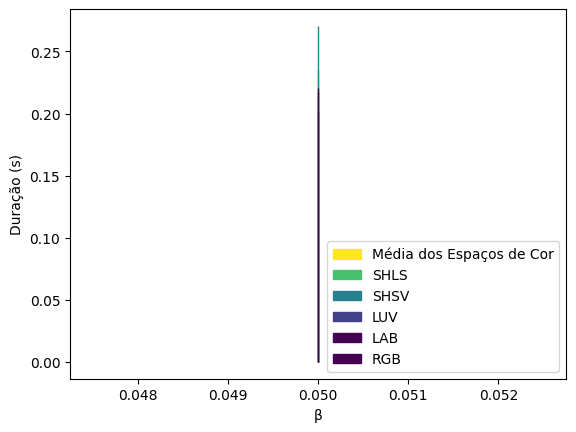

In [124]:

# for color_space in [oob_362_plus_results_over_methods.keys()[1]]:
# for color_space in [*oob_362_plus_results_over_methods.keys()]:
# for i, color_space in enumerate(["Média dos Espaços de Cor"]):
for i, color_space in enumerate(["Média dos Espaços de Cor", "SHLS_results", "SHSV_results", "LUV_results", "LAB_results", "RGB_results"]):
# for i, color_space in enumerate(["SHLS_results", "SHSV_results", "LUV_results", "LAB_results", "RGB_results"]):
    ANALYSIS_SET = "evaluation"
    
    if (color_space == "Média dos Espaços de Cor"):
        # all_colorspaces_methods_results = oob_362_plus_results_over_methods.copy().T
        methods_results = pd.DataFrame()
        methods_names = oob_362_plus_results_over_methods.T.keys()
        
        for method_name in methods_names:
            method_oob_results = reduce_df_dim(oob_362_plus_results_over_methods.T, method_name)
            method_oob_eval_results = reduce_df_dim(method_oob_results, ANALYSIS_SET)[[f"mean_{prop}" for prop in metrics_to_track]]
            methods_results[method_name] = method_oob_eval_results.copy().astype("float").mean()

        # methods_results = reduce_df_dim(methods_results.T, 0)
        methods_results = methods_results
        methods_results = methods_results.T.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)
            
        print("a")
        # print(.apply(lambda same_HPs_methods_col: print(same_HPs_methods_col)))
        # print(methods_results.reset_index().drop("index", axis=1))
    else:
        methods_results = reduce_df_dim(oob_362_plus_results_over_methods, color_space)[[ANALYSIS_SET]]
        methods_results = reduce_df_dim(methods_results, ANALYSIS_SET)
        
        methods_results = methods_results.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)
        
    if (technique_name == "Mean-SD"):
        color_space_label = color_space.replace("_results", "")
        
        methods_results["B"] = methods_results["method_name"].apply(lambda name: float(name.replace("mean_sd_threshold_", "")))
        methods_results[f"mean_{quality_prop}"] = methods_results[f"mean_{quality_prop}"].astype("float")
        
        thresh = 75
        greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
        print(f"{greater_than_thresh["B"].min()} → {greater_than_thresh["B"].max()}")
        
        
        pairs = methods_results.apply(lambda row: (row["B"], float(row[f"mean_{quality_prop}"])), axis=1).to_list()
        pairs = np.array(pairs)
        
        # fig, ax = plt.subplots()
        
        plt.fill_between(pairs[:, 0], np.zeros(len(pairs)), pairs[:, 1], label=color_space_label, color=plt.cm.viridis( ((4-i)/4)**1.2))
        # colors = ["#1b485e", "#326b77", "#568b87", "#80ae9a", "#b5d1ae"]
        # plt.fill_between(pairs[:, 0], np.zeros(len(pairs)), pairs[:, 1], label=color_space, color=colors[i])
        
        # norm = mpl.colors.Normalize(vmin=pairs[:, 1].min(), vmax=pairs[:, 1].max())
        # colormap = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
        # for i in range(len(pairs)):
        #     plt.fill_between(pairs[:, 0][i: i+2], [0], pairs[:, 1][i: i+2], color=plt.cm.viridis(norm(pairs[:, 1][i: i+2])))
        # plt.colorbar(colormap, ax=ax)
            
        plt.legend(loc="lower right")
        plt.ylabel(labels_metrics_to_track[quality_prop])
        plt.xlabel("β")
        # plt.yticks(np.linspace(0, 80, 16).round(0))
        # plt.title(color_space_label)
        # plt.show()
        
    elif (technique_name == "K-Means + KNN"):
        
        def KNN_K_from_method_label(label, N):
            KNN_K_str:str = re.sub(r"KNN K:\s*([^\|]*)\|.*", r" \1", label).replace("_", ".").replace(" ", "")
            
            if (KNN_K_str.replace(".", "").isdigit()):
                return N * float(KNN_K_str)
            
            elif (KNN_K_str == "sqrt"):
                return N ** 0.5
            
            elif (KNN_K_str.startswith("N^")):
                return N ** eval(KNN_K_str.replace("N^", ""))
            
            # KNN_K_str:str = re.sub(r"KNN K: (\d+_?\d*).*$", r"\1", label).replace("_", ".")
            # NN K: sqrt | Kmeans K: 100
        
        N = 100
        methods_results["method_name"] = methods_results["method_name"].apply(lambda name: transform_method_key_into_HPs_labels(name, method_key_to_HPs_labels_mapper))
        methods_results["KNN_K"] = methods_results["method_name"].apply(lambda name: KNN_K_from_method_label(name, N)).astype("float")
        methods_results["Kmeans_K"] = methods_results["method_name"].apply(lambda name: re.sub(r".*Kmeans K: (\d*)", r"\1", name)).astype("float")
        
        thresh = 74.5
        greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
        print(f"K-KNN: {greater_than_thresh["KNN_K"].min()} → {greater_than_thresh["KNN_K"].max()} | {greater_than_thresh["KNN_K"].unique()}")
        print(f"K-Kmeans: {greater_than_thresh["Kmeans_K"].min()} → {greater_than_thresh["Kmeans_K"].max()} | {greater_than_thresh["Kmeans_K"].unique()}")

        # print( methods_results[f"mean_{quality_prop}"].astype("float"))
        # ordered_by_KNN_K = methods_results.nlargest(methods_results.shape[0], "KNN_K")
        # plt.plot(ordered_by_KNN_K["KNN_K"], ordered_by_KNN_K[f"mean_{quality_prop}"])
        # plt.show()
        
        # ordered_by_Kmeans_K = methods_results.nlargest(methods_results.shape[0], "Kmeans_K")
        # plt.plot(ordered_by_Kmeans_K["Kmeans_K"], ordered_by_Kmeans_K[f"mean_{quality_prop}"])
        # plt.show()
        
        # plt.figure(figsize=[18, 6])
        # result_points = methods_results.apply(lambda row: (row["KNN_K"], row["Kmeans_K"], row[f"mean_{quality_prop}"]), axis=1).to_list()
        # plot_3_dim_HPs_Quality_metric(result_points, methods_results[f"mean_{quality_prop}"].astype("float").min(), methods_results[f"mean_{quality_prop}"].astype("float").max())
        # plt.show()
        
        # plot_3D_surface_HP_quality_metric(methods_results["KNN_K"].astype("float"), methods_results["Kmeans_K"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), interpolation="linear", view_init=(90, 0, 0))
        fig, ax = plot_3D_surface_HP_quality_metric(methods_results["KNN_K"], methods_results["Kmeans_K"], methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(90, -90, 0), figsize=(10, 6), interpolation="linear")
        
        # ax.set_title(technique_label, loc="center", x=0.63)
        
        ax.tick_params(axis="x", pad=5)
        ax.set_xlabel("KNN-K", labelpad=10)
        
        ax.set_ylabel("Kmeans-K", labelpad=18)
        ax.tick_params(axis="y", pad=10)
        
        # ax.set_xlim(0, 800)
        # ax.set_ylim(0, 300)
        
        ax.set_zlabel("")
        ax.set_zticks([])
        plt.title(color_space.replace("_results", ""))
        
        plt.show()
        
    
        # Lembrar que a qualidade não está ordenada segundo os HPs, mas de acordo com a ordem da tabela e portanto (acho) não há garantia de ser qualquer ordem útil
        # plt.plot(methods_results[f"mean_{quality_prop}"])
        # plt.show()
    
    elif (technique_name == "MinMax-Slic"):
        methods_results["method_name"] = methods_results["method_name"].apply(lambda name: transform_method_key_into_HPs_labels(name, method_key_to_HPs_labels_mapper))
        methods_results["area"] = methods_results["method_name"].apply(lambda name: re.sub(r"Área Superpixel:\s*(\d+)px².*",r"\1", name)).astype("float")
        methods_results["m"] = methods_results["method_name"].apply(lambda name: re.sub(r".*m:\s*(\d+).*",r"\1", name)).astype("float")
        
        # ordered_by_area = methods_results.nlargest(methods_results.shape[0], "area")
        # plt.plot(ordered_by_area["area"], ordered_by_area[f"mean_{quality_prop}"])
        # plt.show()
        
        # ordered_by_m = methods_results.nlargest(methods_results.shape[0], "m")
        # plt.plot(ordered_by_m["m"], ordered_by_m[f"mean_{quality_prop}"])
        # plt.show()
        
        # result_points = methods_results.apply(lambda row: (row["m"], row["area"], row[f"mean_{quality_prop}"]), axis=1).to_list()
        # plot_3_dim_HPs_Quality_metric(result_points, float(methods_results[f"mean_{quality_prop}"].min()), float(methods_results[f"mean_{quality_prop}"].max()))
        # plt.show()
        
        # fig, ax = plot_3D_surface_HP_quality_metric(methods_results["area"].astype("float"), methods_results["m"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(25, -45, 0), figsize=(10, 6), interpolation="nearest")
        fig, ax = plot_3D_surface_HP_quality_metric(methods_results["area"].astype("float"), methods_results["m"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(90, -90, 0), figsize=(10, 6), interpolation="linear")
        
        ax.set_title(color_space)
        
        ax.set_xlabel("Área do Superpixel", labelpad=10)
        ax.tick_params(axis="x", pad=5)
        
        ax.set_ylabel("m", labelpad=18)
        ax.tick_params(axis="y", pad=10)
        
        ax.set_zlabel("")
        ax.set_xticks([25, 100, 160, 225, 310, 400])
        ax.set_zticks([])
        # ax.set_xlim([25, 400])
        # ax.set_ylim([0, 100])
        plt.show()
        
        
        # Lembrar que a qualidade não está ordenada segundo os HPs, mas de acordo com a ordem da tabela e portanto (acho) não há garantia de ser qualquer ordem útil
        # plt.plot(methods_results[f"mean_{quality_prop}"])
        # plt.show()
    
    

### Dispersion Of Metrics along Methods (Eval Samples)

In [125]:
### Dispersion Of Methods (Eval Samples)

print("================================")
print("Mean ± Dispersion Of Metrics along Methods (Eval Samples)")
print("================================")

dispersion_on_color_space = pd.DataFrame()

for color_space in oob_362_plus_results_over_methods.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_362_plus_results_over_methods), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "evaluation")
    
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    # Ignoring metric's uncertainty because this would result on mean dispersion having double uncertainty: because of OOB mean & bevause color space dispersion
    # As OOB dispersion is alredy represented in other graph, it will be ignored to make easier to understand the uncertainty as color space dispersion
    dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col.apply(lambda x: float(x))), axis=0)
    dispersion_on_color_space[color_space] = dispersion_of_cols
    # With OOB Dispersion
    # dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col))
    
    print("")
    print(color_space)
    print("-------")
    display(dispersion_of_cols)
    
dispersion_on_color_space = dispersion_on_color_space.transpose()
mean_dispersion_along_color_space = dispersion_on_color_space.apply(lambda col: mean_w_precision(col.apply(lambda x: x.uncertainty)), axis=0)

print()
display(dispersion_on_color_space)
print("Mean Dispersion Along Color Spaces ")
print("-------")
display(mean_dispersion_along_color_space)

Mean ± Dispersion Of Metrics along Methods (Eval Samples)

SHLS_results
-------


mean_MCC                    50.4019085567
mean_Ps                 0.000254269883083
mean_time_to_analyze       0.235487241896
dtype: object


SHSV_results
-------


mean_MCC                    50.4085993826
mean_Ps                 1.99055195276e-05
mean_time_to_analyze       0.270596234712
dtype: object


LAB_results
-------


mean_MCC                    50.8283529548
mean_Ps                 0.000659976073664
mean_time_to_analyze       0.220496103852
dtype: object


LUV_results
-------


mean_MCC                   50.9814366409
mean_Ps                 0.00026149187058
mean_time_to_analyze      0.217184804917
dtype: object


RGB_results
-------


mean_MCC                 50.9194426275
mean_Ps                 0.000304385327
mean_time_to_analyze    0.201938909352
dtype: object

,mean_MCC,mean_Ps,mean_time_to_analyze
SHLS_results,50.4019085567,0.000254269883083,0.235487241896
SHSV_results,50.4085993826,1.99055195276e-05,0.270596234712
LAB_results,50.8283529548,0.000659976073664,0.220496103852
LUV_results,50.9814366409,0.00026149187058,0.217184804917
RGB_results,50.9194426275,0.000304385327,0.201938909352


Mean Dispersion Along Color Spaces 
-------


mean_MCC                0.0
mean_Ps                 0.0
mean_time_to_analyze    0.0
dtype: object

### Best Methods (Test Samples Only)

In [126]:
# Rendering OB.632+ CV Quality & Variance Estimates for All Test sets from oob samples

print("================================")
print("TOP 15 BEST METHODS FOR TEST SETS")
print("================================")

for color_space in oob_362_plus_results_over_methods.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_362_plus_results_over_methods), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "test")
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    ordered_by_largest_quality = methods_on_color_space_test_results.astype("float").nlargest(15, f"mean_{sort_metric}")
    best_method = ordered_by_largest_quality.iloc[0]
    
    print("")
    print(color_space)
    print("-------")
    display(ordered_by_largest_quality)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")

TOP 15 BEST METHODS FOR TEST SETS

SHLS_results
-------


,mean_MCC,mean_Ps,mean_time_to_analyze
mean_sd_threshold_0.05,50.38407,0.000293,0.236167



mean_sd_threshold_0.05: 0.24%

SHSV_results
-------


,mean_MCC,mean_Ps,mean_time_to_analyze
mean_sd_threshold_0.05,50.392224,0.000024,0.271104



mean_sd_threshold_0.05: 0.27%

LAB_results
-------


,mean_MCC,mean_Ps,mean_time_to_analyze
mean_sd_threshold_0.05,50.806974,0.000735,0.220428



mean_sd_threshold_0.05: 0.22%

LUV_results
-------


,mean_MCC,mean_Ps,mean_time_to_analyze
mean_sd_threshold_0.05,50.945207,0.000268,0.214816



mean_sd_threshold_0.05: 0.21%

RGB_results
-------


,mean_MCC,mean_Ps,mean_time_to_analyze
mean_sd_threshold_0.05,50.899459,0.000342,0.218294



mean_sd_threshold_0.05: 0.22%


### Are The Results Of The Multiple Methods pretty Distinct For The Same Imgs? *(SD for Same Idx Condo Img Results)*

In [127]:
def analysis_data_series_to_quality_metrics_df(analysis_data_series):
    return pd.DataFrame(
        analysis_data_series.apply(lambda data: data["classification_evaluation_metrics"])     
        .to_list()
    )

In [128]:
def compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index):
    
    # quality_metrics_separated_by_condo_idx_df = analysis_data_series_to_quality_metrics_df(data_all_methods_about_specific_condo_index)[metrics_to_track]
    data_all_methods_about_specific_condo_index = pd.DataFrame(data_all_methods_about_specific_condo_index.to_dict()).transpose()
    quality_metrics_separated_by_condo_idx_df = pd.DataFrame()
    for metric, method_to_extract in method_to_extract_metric_from_ds_sample.items():
        quality_metrics_separated_by_condo_idx_df[metric] = method_to_extract(data_all_methods_about_specific_condo_index)

    mean_quality_metrics_separated_by_condo_idx_df = quality_metrics_separated_by_condo_idx_df.apply(mean_w_precision, axis=0)
    
    return mean_quality_metrics_separated_by_condo_idx_df


def calculate_quality_measurements_from_each_condo_idx_separetely(condo_analysis_series):
    return condo_analysis_series.apply(lambda data_all_methods_about_specific_condo_index: 
        compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index)
    ).transpose()


def print_uncertainty_mean_of_Series(series, text="Uncertainty Mean:"):
    print("")
    print(text)
    print("---")
    print(series.apply(lambda x: np.array([*map(lambda val: val.uncertainty, x.to_list())]).mean()))
    print("")

In [129]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx ---

flattened_color_space_oriented_data = color_space_oriented_df.stack().reset_index()[0].to_list() # To Flatten Multi-Column Table

#To Quantify The Uncertainty Of All COndos, Independetly of Condo Idx
# Why Does This result So Different Of The Mean of Each Condo iDx uncertainty mean
# flattened_color_space_oriented_data = pd.DataFrame(m).stack().reset_index()[0]

# ---
condo_indexed_data_df = pd.DataFrame(flattened_color_space_oriented_data)

all_db_mean_quality_of_each_condo_separetely = calculate_quality_measurements_from_each_condo_idx_separetely(condo_indexed_data_df)
print(all_db_mean_quality_of_each_condo_separetely)
print_uncertainty_mean_of_Series(all_db_mean_quality_of_each_condo_separetely)

               MCC             Ps time_to_analyze
0   50.524 ± 0.246            0.0   0.206 ± 0.013
1             50.0            0.0   0.211 ± 0.016
2   50.442 ± 0.378      0.0 ± 0.0   0.212 ± 0.015
3   51.019 ± 0.414            0.0   0.211 ± 0.014
4   51.444 ± 0.708            0.0   0.213 ± 0.021
5    51.12 ± 0.152            0.0   0.221 ± 0.036
6   50.985 ± 0.598  0.001 ± 0.001   0.216 ± 0.031
7   51.127 ± 0.289            0.0   0.217 ± 0.025
8    50.381 ± 0.33            0.0   0.219 ± 0.027
9   50.709 ± 0.585            0.0    0.214 ± 0.02
10  50.318 ± 0.152            0.0   0.284 ± 0.026
11  50.899 ± 0.134  0.001 ± 0.001   0.274 ± 0.018
12  50.292 ± 0.161  0.003 ± 0.002   0.276 ± 0.017
13  50.577 ± 0.239      0.0 ± 0.0   0.281 ± 0.024

Uncertainty Mean:
---
MCC                0.313282
Ps                 0.000276
time_to_analyze    0.021653
dtype: float64



In [130]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx Divided by Color Space ---

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_acc_df = calculate_quality_measurements_from_each_condo_idx_separetely(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_acc_df)
    print_uncertainty_mean_of_Series(each_condo_idx_mean_acc_df)

--- SHLS_results ---
              MCC                 Ps time_to_analyze
0   50.2892750282                0.0  0.213280400028
1            50.0                0.0  0.222339199972
2   49.9508124638  0.000799801649191  0.215546799998
3   50.7111904485                0.0   0.21639310004
4   50.7053428197                0.0  0.212264800037
5   50.9987179732                0.0  0.211157399986
6   50.2678554983                0.0  0.212270900025
7   50.8469951497                0.0  0.212246100011
8            50.0                0.0  0.217435600003
9            50.0                0.0  0.220764799975
10  50.4342425933                0.0  0.285740203717
11  50.9504871802  0.000298918660875  0.282802659583
12  49.9791069261   0.00267706440853   0.28529379668
13  50.4303100373                0.0  0.308829344277

Uncertainty Mean:
---
MCC                0.0
Ps                 0.0
time_to_analyze    0.0
dtype: float64

--- SHSV_results ---
              MCC                 Ps time_to_analyze
0 

### Which Condo Has Biggest Deviation In Same Method Accuracy

In [131]:

def quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_df):

    def quantify_quality_deviation(all_condo_analysis):
        # all_condo_analysis = analysis_data_series_to_quality_metrics_df(all_condo_analysis)[metrics_to_track]
        condo_analysis_metrics_df = data_all_methods_about_specific_condo_index = pd.DataFrame(all_condo_analysis.to_dict()).transpose()
        all_condo_analysis = pd.DataFrame()
        for metric, method_to_extract in method_to_extract_metric_from_ds_sample.items():
            all_condo_analysis[metric] = method_to_extract(condo_analysis_metrics_df)
        
        mean = all_condo_analysis[sort_metric].mean()
        all_condo_analysis = all_condo_analysis.apply(lambda x: mean - x, axis=0)
        
        return all_condo_analysis.to_dict("records")

    deviation_each_condo_analysis_df = all_condos_analysis_separated_df.apply(quantify_quality_deviation, axis=0)
    mean_deviation_each_condo_analysis_df = deviation_each_condo_analysis_df.apply(
        lambda specific_metric_deviation_series: 
            pd.DataFrame(specific_metric_deviation_series.to_list()).apply(lambda metric_column: metric_column.abs().mean())
            
        , axis=0).transpose()
    mean_deviation_each_condo_analysis_df = mean_deviation_each_condo_analysis_df.rename({col_name:f"{col_name}_deviation" for col_name in mean_deviation_each_condo_analysis_df.keys()}, axis=1)

    return mean_deviation_each_condo_analysis_df

In [132]:
# Quantify Metric Deviation Of Each Condo Idx from all DB --- 

# Analyze How [[{RecordA}, {RecordA1}], [{RecordB}, {RecordB1}]] --> [{0:{RecordA}, 1:{RecordA1}}, {0:{RecordB}, 1:{RecordB1}}]
all_condos_analysis_separated_by_method_color_space = color_space_oriented_df.stack().reset_index()[0].to_list()
all_condos_analysis_separated_by_method_color_space_df = pd.DataFrame(all_condos_analysis_separated_by_method_color_space)

quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_by_method_color_space_df)

,MCC_deviation,Ps_deviation,time_to_analyze_deviation
0,50.317272,0.206249,0.010911
1,49.789270,0.210730,0.014160
2,50.229357,0.211666,0.012125
3,50.808220,0.211183,0.011593
4,51.230955,0.213489,0.015377
5,50.898419,0.221170,0.028402
6,50.769792,0.215058,0.023775
7,50.909133,0.217438,0.019607
8,50.162022,0.219385,0.021301
9,50.494479,0.214194,0.016881


In [133]:
# Quantify Metric Deviation Of Each Condo Idx Separeted by Color Space --- 

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_abs_deviation_df = quantify_mean_abs_deviation_of_each_condo_idx(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_abs_deviation_df)
    print("")
    

--- SHLS_results ---
    MCC_deviation  Ps_deviation  time_to_analyze_deviation
0       50.075995      0.213280                        0.0
1       49.777661      0.222339                        0.0
2       49.735266      0.214747                        0.0
3       50.494797      0.216393                        0.0
4       50.493078      0.212265                        0.0
5       50.787561      0.211157                        0.0
6       50.055585      0.212271                        0.0
7       50.634749      0.212246                        0.0
8       49.782564      0.217436                        0.0
9       49.779235      0.220765                        0.0
10      50.148502      0.285740                        0.0
11      50.667685      0.282504                        0.0
12      49.693813      0.282617                        0.0
13      50.121481      0.308829                        0.0

--- SHSV_results ---
    MCC_deviation  Ps_deviation  time_to_analyze_deviation
0       50.06

### Quality Of Methods (Resubsitution)

In [134]:
# QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)

print("--------------------")
print("QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)")
print("--------------------")
print()

methods_quality = {}
for color_space in color_space_oriented_df:
    # Init ---
    methods_quality[color_space] = {}
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for method_name in methods_condos_ds_df.keys():
        # Getting Metrics Df ---
        crr_method_props = reduce_df_dim(methods_condos_ds_df, method_name)
        
        # Save Tracked Metrics ---
        methods_quality[color_space][method_name] = {}
        for metric, method_to_extract in method_to_extract_metric_from_ds_sample.items():
            methods_quality[color_space][method_name][f"mean_{metric}"] = mean_w_precision(method_to_extract(crr_method_props))
        
    # Computing Best Method Of Color Space --
    best_methods_df = pd.DataFrame(methods_quality[color_space]).transpose()
    best_methods_df_w_no_uncertainty = pd.DataFrame(methods_quality[color_space]).transpose()
    
    # Ordering By Quality --
    best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].astype("float")
    # Ordering By Less Uncertainty --
    # best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].apply(lambda x: 100 - x.uncertainty)
    
    best_methods_names = [*best_methods_df_w_no_uncertainty.nlargest(15, f"mean_{sort_metric}").index]
    
    best_methods_df = best_methods_df.loc[best_methods_names]#[[f"mean_{sort_metric}"]]
    
    best_method = best_methods_df.iloc[0]
    methods_quality[color_space]["best"] = {"name": best_method.name, "quality": best_method[f"mean_{sort_metric}"]}
    
    
    # Formatting ---
    def format_best_methods_for_render(row):
        new_row = {}
        new_row[labels_metrics_to_track[sort_metric]] = f"{round(row[f"mean_{sort_metric}"], 2).format_in_str("%")}"
        new_row["Duração"] = f"{round(row["mean_time_to_analyze"], 2)}s"
        
        return pd.Series(new_row)
    
    
    best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1)
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"K = {name.replace("Kmeans_k_", "")}")
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"Coeff = {name.replace("mean_sd_threshold_", "")}")
    
    
    # Rendering ---    
    print("")
    print(color_space)
    print("-------")
    print(best_methods_df_formatted)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")
    
    # dfi.export(best_methods_df_formatted.style
    #            .set_caption(color_space.replace("_results", "")),
    #             f"{technique_name}_best_methods_{color_space}.png")
    

--------------------
QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)
--------------------


SHLS_results
-------
                          Duração (s)       Duração
mean_sd_threshold_0.05  0.24% ± 0.03%  0.24 ± 0.03s

mean_sd_threshold_0.05: 0.24 ± 0.03%

SHSV_results
-------
                          Duração (s)       Duração
mean_sd_threshold_0.05  0.27% ± 0.03%  0.27 ± 0.03s

mean_sd_threshold_0.05: 0.27 ± 0.03%

LAB_results
-------
                          Duração (s)       Duração
mean_sd_threshold_0.05  0.22% ± 0.03%  0.22 ± 0.03s

mean_sd_threshold_0.05: 0.22 ± 0.03%

LUV_results
-------
                          Duração (s)       Duração
mean_sd_threshold_0.05  0.22% ± 0.03%  0.22 ± 0.03s

mean_sd_threshold_0.05: 0.22 ± 0.03%

RGB_results
-------
                          Duração (s)       Duração
mean_sd_threshold_0.05  0.21% ± 0.03%  0.21 ± 0.03s

mean_sd_threshold_0.05: 0.21 ± 0.03%


---

### Processing Data To Render

In [135]:
""" Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} """

' Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} '

In [136]:
# sorted_kfolds_eval_method_quality = bubble_sort_dicts_based_on_property(kfolds_eval_method_quality, f"['mean_{sort_metric}']")

In [137]:
# specific_method_data = pd.DataFrame(pd.DataFrame(methods_quality).transpose()["Kmeans_k_200"]).transpose().to_dict("records")[0]
# sorted_specifc_method_quality = bubble_sort_dicts_based_on_property(specific_method_data, f"['mean_{sort_metric}']")

In [138]:
# OOB Data {color_space: {method:resultsDict, ...}} → {color_space: (best_method_name, best_method_result)}
oob_best_method_per_color_space = {color_space: [*best_methods.items()][0] for color_space, best_methods in oob_best_methods_results_ordered_by_best_method_rate.items()}
del oob_best_method_per_color_space["All Color Spaces"]

# {color_space: best_method_results}
oob_best_method_results_per_color_space = {color_space: method_results for color_space, (_, method_results) in oob_best_method_per_color_space.items()}
# {color_space: best_method_name}
oob_best_method_name_per_color_space = {color_space: method_name for color_space, (method_name, _) in oob_best_method_per_color_space.items()}

In [139]:
# method_quality_to_render = specific_method_data
# method_quality_to_render = kfolds_eval_method_quality
method_quality_to_render = oob_best_method_results_per_color_space.copy()
labels_metrics_to_tracks_in_render = {**labels_metrics_to_track, "Was The Best in How Many Samples":"Melhor Métodos em Amostras (%)"}


# Adding "Was The Best in How Many Samples" to df ---
method_quality_to_render = pd.DataFrame(method_quality_to_render)
method_quality_to_render.loc["Was The Best in How Many Samples"] = method_quality_to_render.loc["Was The Best in How Many Samples"].apply(lambda val: numberWithUncertainty(val, 0))

# Changing Time Scale ---
if (technique_name in ["K-Means + KNN", "MinMax-Slic"]):
    method_quality_to_render.loc["mean_time_to_analyze"] = method_quality_to_render.loc["mean_time_to_analyze"].apply(lambda val: val/5)
    labels_metrics_to_tracks_in_render["time_to_analyze"] = "Duração (s/5)"
    

# Saving Changes
method_quality_to_render = method_quality_to_render.to_dict()
# ----

sorted_method_quality_to_render = bubble_sort_dicts_based_on_property(method_quality_to_render, f"['mean_{sort_metric}']") 

metrics_to_plot = copy.deepcopy(metrics_to_track)
# metrics_to_plot = ["Was The Best in How Many Samples", "MCC", "normPs", "time_to_analyze"]
# metrics_to_plot = [ "Ps", "time_to_analyze", quality_prop]
# metrics_to_plot = [*metrics_to_plot, "Was The Best in How Many Samples"]

In [140]:
to_render = {
    "labels": [],
    "features_labels": []
}

for color_space, data in sorted_method_quality_to_render:
    to_render["labels"].append(color_space)

    for metric in metrics_to_plot:
        metric_label = labels_metrics_to_tracks_in_render[metric]
        
        if not metric_label in to_render:
            to_render[metric_label] = []
            to_render["features_labels"].append(metric_label)

        match (metric):
            case "Was The Best in How Many Samples":
                to_render[metric_label].append(round(data[metric], 2))       
            case _:
                to_render[metric_label].append(round(data[f"mean_{metric}"], 2))       
                # if metric == "Ps":
                    # print(round(data[f"mean_{metric}"], 2))
                # else:
                # print(metric)
                    
                 
    
to_render["labels"] = [*map(lambda label: label.replace("_results", ""), to_render["labels"])]

# Render HPs Configurations At Xticks ----

# to_render["labels"] = [*map(lambda label_data: f"{label_data[1]}\n{transform_method_key_into_HPs_labels([*oob_best_method_name_per_color_space.values()][label_data[0]], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), enumerate(to_render["labels"]))]

to_render["labels"] = [*map(lambda color_space_label: f"{color_space_label}\n{transform_method_key_into_HPs_labels(oob_best_method_name_per_color_space[color_space_label+"_results"], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), to_render["labels"])]

### Render Graphs

In [141]:
#TODO: Maybe is better to use pd.DataFrame instead of heightsCollectio & labels
# It will allow different object structures to represent the data - as there are many structures to create dfs
# It will use an alredy know structure so less atrict to use the method

def plt_bars_with_spacing(heightsCollection, labels, overBarLabels=None, width=.25, spacing_between_bars=5, spacing_between_labels=1.3, overBarOffset=4.5, fontsize=8, labelsFontSize=8, barsColors=None, errorMarginColors=None):
    spacement = np.arange(len(labels))
    
    if (type(overBarOffset) in [int, float]):
        overBarOffset = [overBarOffset] * len(heightsCollection.keys())
    
    for i, (attribute, heights) in enumerate(heightsCollection.items()):
        
        offset = i*(width + spacing_between_bars)
        # base_positions = spacement * (len(labels)*spacing_between_labels)
        size_of_single_label = ((width + spacing_between_bars) * len(heightsCollection)) + spacing_between_labels
        base_positions = spacement * size_of_single_label
        positions = base_positions + offset
        
        barsColor = None if barsColors is None else barsColors[i]
        bar = plt.bar(positions, [*map(lambda x: float(x), heights)], width, label=attribute, color=barsColor)  
        
        if (not errorMarginColors is None):
            errorbarsColor = errorMarginColors[i]
            plt.errorbar(positions, np.array(heights), [*map(lambda propVal:propVal.uncertainty, heights)], None, capsize=5,  ecolor=errorbarsColor, fmt="_")
        
        if overBarLabels is None:
            for j, height in enumerate(heights):
                plt.annotate(heights[j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
        else:
            for j, height in enumerate(heights):
                plt.annotate(overBarLabels[attribute][j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
            
        
        # Just The Last xtick will appear, so "Postions" gonna be last position
        plt.xticks( (base_positions + positions) * 0.5
                   , labels, fontsize=labelsFontSize)
        plt.legend(loc='lower center')

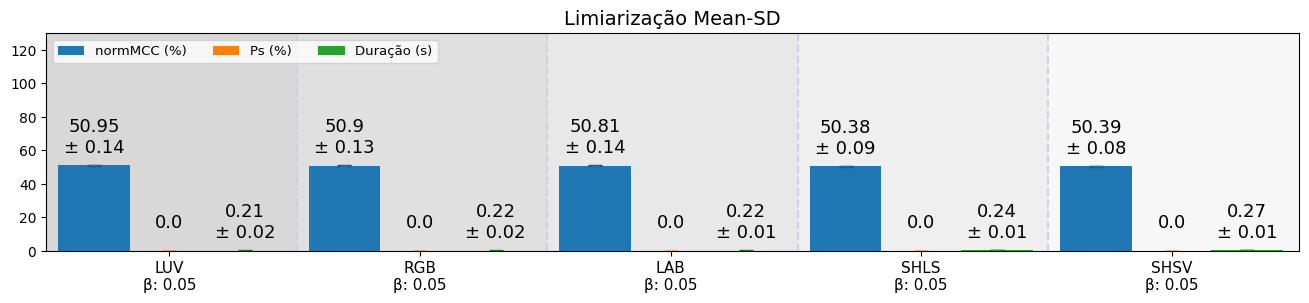

In [142]:
# total_bars = len(to_render["features_labels"]) * len(to_render["labels"])

# 2 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# width = 1.5
# spacing_between_bars = width * 0.65
# spacing_between_labels = 1.3
# overBarOffset = 3.5

# 3 Bars / Color Space
# plt.figure(figsize=[9.2, 7])
# width = 0.8
# spacing_between_bars = 0.7
# spacing_between_labels =   1.1
# overBarOffset = [6, 8, 11.5]

# Test New 3 Bars ---
# plt.figure(figsize=[11, 6])
plt.figure(figsize=[13.19, 2.9])
width = 9
spacing_between_bars = 0.5
# spacing_between_labels = 3
# spacing_between_labels = 3
spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
# overBarOffset = 7
overBarOffset = 17


# 4 Bars / Color Space
# plt.figure(figsize=[10, 7])
# width = 0.9
# spacing_between_bars = 1.9
# spacing_between_labels =   2.72
# overBarOffset = [5.7, 7.7, 8.5, 3.5]

# print(len(({metric: to_render[metric] for metric in to_render["features_labels"]})["Duração (s/5)"]))

plt_bars_with_spacing(
    # {to_render["features_labels"][i]: to_render[metrics_to_track[i]] for i in range(0, len(to_render["features_labels"]))},
    {metric: to_render[metric] for metric in to_render["features_labels"]},
    
    to_render["labels"],
    
    # {to_render["features_labels"][i]: [*map(lambda x: x.format_in_str("", 2).replace(" ", "\n", 1), to_render[metrics_to_track[i]])]
    # for i in range(0, len(to_render["features_labels"]))},
    {metric: [*map(lambda metric_val: str(metric_val).replace(" ", "\n", 1), to_render[metric])] 
    for metric in to_render["features_labels"]},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    fontsize=13,
    labelsFontSize=11,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    errorMarginColors=["#175887", "#db6600", "#217821", "#C22"]
    
    # barsColors=[ "#F55", "#1f77b4", "#ff7f0e", "#2ca02c"],
    # errorMarginColors=["#C22", "#175887", "#db6600", "#217821"]
    
)

plt.ylim([0, 130])
plt.tight_layout()
# plt.margins(0.01)
plt.margins(0.0)
# plt.grid(axis="x")
# plt.plot([(width+spacing_between_bars)*2.5 + spacing_between_labels * 0.5]*2,[0, 130], ls="--", color="#cfd0e6")

size_of_single_label = ((width + spacing_between_bars) * len(to_render["features_labels"])) + spacing_between_labels
for labelIdx in range(len(to_render["labels"])):
    separationPos = (size_of_single_label*labelIdx - 0.5 * (width + spacing_between_labels))
        
    nextSeparationPos = (size_of_single_label*(labelIdx+1) - 0.5 * (width + spacing_between_labels))
    plt.axvspan(separationPos, nextSeparationPos,  facecolor=f"{(1-0.15*len(to_render["labels"]))+  0.15*(labelIdx)}", alpha=0.2, zorder=-1)
        
    plt.plot([separationPos]*2,[0, 130], ls="--", color="#cfd0e6")

# REMEMEBR MEAN_SD HAS DIFFS COEFS FOR EACH COLOR SPACE
plt.title(technique_label, fontsize=14)
plt.legend(loc="upper left", fontsize=9.5, ncol=len(to_render["features_labels"]))
plt.savefig(f"./{sort_metric}/{technique_name}/{technique_name}- OOB Bars All Color Spaces Results.png")
plt.show()

In [143]:
# %matplotlib qt5
%matplotlib inline

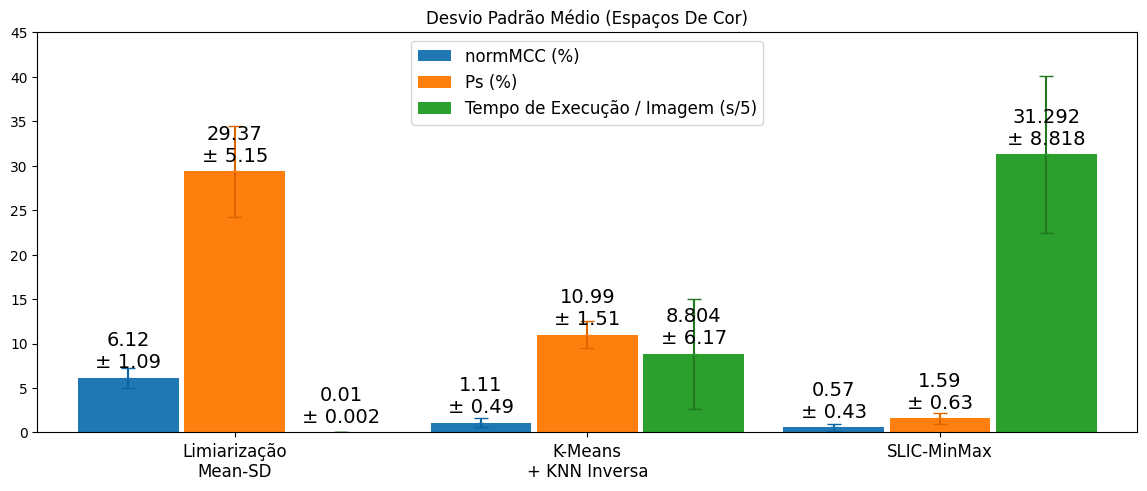

In [144]:
# 2 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# width = 1.5
# spacing_between_bars = width * 0.65
# spacing_between_labels = 1.3
# overBarOffset = 3.5

# 3 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# plt.figure(figsize=[11, 6])
# width = 1.5 * 2/3 * 1.1
# spacing_between_bars = width * 1.3
# spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
# # overBarOffset = 6

# Test New 3 Bars ---
plt.figure(figsize=[11, 4])
width = 2.3
spacing_between_bars = 0.1
spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
overBarOffset = 3
# overBarOffset = 6

width = 9
spacing_between_bars = 0.5
spacing_between_labels = 3

# 4 Bars / Color Space
# plt.figure(figsize=[12, 6])
# width = 1.5 * 2/3 * 1.1
# spacing_between_bars = width * 0.65 * 2
# spacing_between_labels = 2.5
# overBarOffset = 5.5

# Mean SD Dispersion Mean along Color Spaces
# -------
# mean_MCC                  6.117 ± 1.094
# mean_balancedAccuracy     8.875 ± 1.076
# mean_normPs              29.371 ± 5.152
# mean_time_to_analyze      0.051 ± 0.012
# mean_Ps                 29.371 ± 5.152


# Mean Kmeans+KNN Dispersion Mean along Color Spaces
# -------
# mean_MCC                    1.11 ± 0.487
# mean_balancedAccuracy      0.705 ± 0.252
# mean_normPs               10.993 ± 1.513
# mean_time_to_analyze     44.019 ± 30.847
# mean_Ps                  10.993 ± 1.513

# Mean SLIC-MinMax Dispersion Mean along Color Spaces
# -------
# mean_balancedAccuracy         0.355 ± 0.048
# mean_accuracy                  0.457 ± 0.21
# mean_F1Score                  0.915 ± 0.718
# mean_MCC                      0.566 ± 0.428
# mean_time_to_analyze       156.455 ± 44.092
# mean_overselectionIndex       3.274 ± 1.238
# mean_recall                   0.796 ± 0.112
# mean_precision                 1.862 ± 1.65
# mean_normPs                   1.587 ± 0.627
# mean_Ps                    1.587 ± 0.627

# Mean-SD; KNN; SLIC
dataToPlotNow =     {
        "normMCC (%)": [
            numberWithUncertainty.from_str("6.12 ± 1.09"),
            numberWithUncertainty.from_str("1.11 ± 0.49"),
            numberWithUncertainty.from_str("0.57 ± 0.43")
        ],
        "Ps (%)": [
            numberWithUncertainty.from_str("29.37 ± 5.15"),
            numberWithUncertainty.from_str("10.99 ± 1.51"),
            numberWithUncertainty.from_str("1.59 ± 0.63")
        ],
        # "normPs (%)": [
        #     numberWithUncertainty.from_str("29.37 ± 5.15"),
        #     numberWithUncertainty.from_str("10.99 ± 1.51"),
        #     numberWithUncertainty.from_str("1.59 ± 0.63")
        # ],
        "Tempo de Execução / Imagem (s/5)": [
            numberWithUncertainty.from_str("0.05 ± 0.01")/5,
            numberWithUncertainty.from_str("44.02 ± 30.85")/5,
            numberWithUncertainty.from_str("156.46 ± 44.09")/5,
        ]
    }

plt_bars_with_spacing(
    # {to_render["features_names"][i]: to_render[metrics_to_track[i]] for i in range(0, len(to_render["features_names"]))},
    dataToPlotNow,
    
    # ["Limiarização\nMean-SD", "K-Means\n+ KNN Inversa"],
    ["Limiarização\nMean-SD", "K-Means\n+ KNN Inversa", "SLIC-MinMax"],
    
    # {to_render["features_names"][i]: [*map(lambda x: x.format_in_str("", 2).replace(" ", "\n", 1), to_render[metrics_to_track[i]])]
    # for i in range(0, len(to_render["features_names"]))},
    # None,
    {attribute: [str(val).replace(" ±", "\n±") for val in dataToPlotNow[attribute]] for attribute in dataToPlotNow.keys()},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    # fontsize=7.5,
    fontsize=14,
    labelsFontSize=12,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    # barsColors=["#F55"],
    
    errorMarginColors=["#0a63a3", "#db6600", "#217821", "#C22"]
    # errorMarginColors=["#C22"]
    # None
)

plt.title("Desvio Padrão Médio (Espaços De Cor)")
plt.margins(.04)

plt.ylim([0, 45])
plt.legend(loc="upper left")

# plt.ylim([0, 160])
# plt.legend(loc="upper left")

# plt.tight_layout(h_pad=0)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.legend(loc="upper center", fontsize=12)
plt.show(block=True)

In [145]:
mean_sd = [
    numberWithUncertainty.from_str("76.81 ± 1.57"),
    numberWithUncertainty.from_str("76.53 ± 1.66"),
    numberWithUncertainty.from_str("75.05 ± 1.42"),
    numberWithUncertainty.from_str("75.99 ± 1.63"),
    numberWithUncertainty.from_str("70.18 ± 2.42"), 
]

kmeans_knn = [
    numberWithUncertainty.from_str("75.35 ± 2.37"),
    numberWithUncertainty.from_str("74.69 ± 2.19"),
    numberWithUncertainty.from_str("76.01 ± 1.94"),
    numberWithUncertainty.from_str("75.07 ± 1.85"),
    numberWithUncertainty.from_str("74.93 ± 2.02"),
]

slic_min_max = [
    numberWithUncertainty.from_str("78.28 ± 2.03"),
    numberWithUncertainty.from_str("78.21 ± 2.03"),
    numberWithUncertainty.from_str("72.0 ± 1.84"),
    numberWithUncertainty.from_str("75.75 ± 2.0"),
    numberWithUncertainty.from_str("70.96 ± 2.22"),
]

min_max = [
    76.25,
    76.91,
    80.22,
    81.66,
    81.67  
]

crr_method_data = slic_min_max
crr_method_data = np.array( [*map(lambda val: val.value, crr_method_data)] )

print(f"Mean ± SD: {mean_w_precision(crr_method_data)}")
print(f"Amplitude: {crr_method_data.max() - crr_method_data.min()}")
print(f"MIN: {crr_method_data.min()}; MAX: {crr_method_data.max()}")

Mean ± SD: 75.04 ± 3.064
Amplitude: 7.320000000000007
MIN: 70.96; MAX: 78.28


In [146]:

prevalences = []
condo_ds_collection_example = color_space_oriented_df.iloc[0, 0]
for condo_ds in condo_ds_collection_example:
    confusion_matrix = condo_ds["classification_evaluation_metrics"]["typesDistribution"]
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    
    prevalence = round(100*P/(P+N), 2)
    prevalences.append(prevalence)

prevalences = np.array(prevalences)
prevalence_df = pd.DataFrame()
prevalence_df["Prevalência"] = prevalences
display(prevalence_df.T)

print(f"Mean ± SD: {mean_w_precision(prevalences)}")
print(f"Amplitude: {prevalences.max() - prevalences.min()}")
print(f"MIN: {prevalences.min()}; MAX: {prevalences.max()}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Prevalência,19.21,12.14,12.1,42.6,7.58,7.15,56.34,17.99,8.23,4.78,14.36,24.33,12.73,38.61


Mean ± SD: 19.868 ± 14.879
Amplitude: 51.56
MIN: 4.78; MAX: 56.34


In [147]:

scale_list = [0.3076923076923077,0.2150537634408602,0.2222222222222222,0.07692307692307693,0.23255813953488372,0.25641025641025644,0.36363636363636365,0.1801801801801802,0.1801801801801802,0.25641025641025644,0.12195121951219513,0.14925373134328357,0.14492753623188406,0.10101010101010101]
scale_list = np.array(scale_list).round(3)

airbus_sources = [6,5,9,11,12,13,1,7,2,4,8,10]
other_sources = [0, 3]
# scale_list = scale_list[airbus_sources]
scale_list = scale_list[other_sources]

display(pd.DataFrame(scale_list).T)
print(f"Mean ± SD: {mean_w_precision(scale_list)}")
print(f"Amplitude: {scale_list.max() - scale_list.min()}")
print(f"MIN: {scale_list.min()}; MAX: {scale_list.max()}")

# with open("xxx.txt", "w") as f:
#     f.write(pd.DataFrame(scale_list).T.to_latex())

,0,1
0,0.308,0.077


Mean ± SD: 0.192 ± 0.116
Amplitude: 0.23099999999999998
MIN: 0.077; MAX: 0.308


In [148]:
# "5": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "6": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "7": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "9": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "11":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "12":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "13":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"

# "1": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "2": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "4": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022"

# "8": "Imagery ©2023 Airbus, Map data ©2023"
# "10":"Imagery ©2023 Airbus, Map data ©2023"

# "0": "Map data ©2022"
# "3": "Map data ©2022. Map data ©2022" 

sources = {
    "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023": 7,
    "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022": 3,
    "Imagery ©2023 Airbus, Map data ©2023": 2,
    "Map data ©2022": 1,
    "Map data ©2022. Map data ©2022": 1
}

summation = np.array([*sources.values()]).sum()
table = {}
for source, freq in sources.items():
    percentual_freq = round(100*freq/summation, 2)
    print(f"{freq}/{summation}")
    print(f"{percentual_freq} | {source}")
    table[source] = {"Percentual do Dataset": percentual_freq}
    
df = pd.DataFrame(table)
with open("latex_distribution_maps_image_providers.txt", "w") as f:
    f.write(df.T.to_latex())

7/14
50.0 | Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023
3/14
21.43 | Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022
2/14
14.29 | Imagery ©2023 Airbus, Map data ©2023
1/14
7.14 | Map data ©2022
1/14
7.14 | Map data ©2022. Map data ©2022


{-9: [20.12730476444287, 9.664544486507989, 12.765186641264295, 19.283837331050638, 12.44627740057824, 14.528857940009566, 22.260076153202323, 9.195250538636115, 10.357549935774465, 14.724558511258312, 17.265224374500956, 8.966972832664801, 8.402059388920433, 12.63645244531757], -8: [16.22098821606946, 7.2140174856101345, 10.157987220542804, 15.404948775001968, 9.720408391611231, 11.454398093920917, 17.512568390236783, 7.1637553543641665, 8.304431048856834, 11.644845198410431, 14.277698112494447, 7.297005615880188, 6.790155297984714, 10.27763920297243], -7: [12.502158468260763, 4.8447200621627, 7.640173534566612, 11.712230590994338, 7.092470028334112, 8.502094926633061, 13.036313011466632, 5.188428931079829, 6.308078796155829, 8.687497298932538, 11.402902630414378, 5.66513576763447, 5.213938465328601, 7.992154275914305], -6: [8.959006589063838, 2.5531013770701607, 5.207705770032857, 8.193956762857718, 4.557826817629496, 5.665561627823927, 8.81103253221995, 3.2672195145286733, 4.3664195

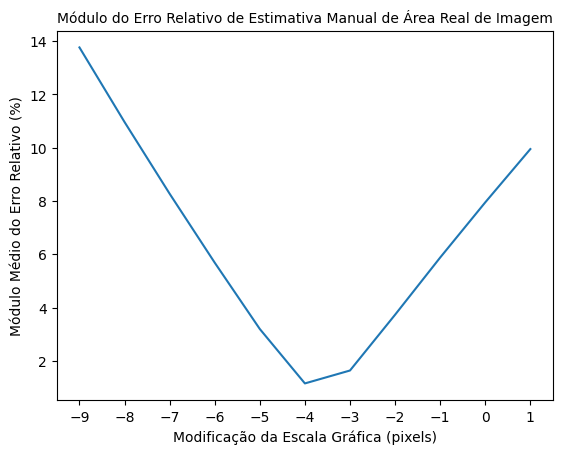

In [149]:
import posProcess.scaleImgAnalyzer as scaleImgAnalyzer
from config import *

from matplotlib.ticker import MaxNLocator, LinearLocator

def compute_area_estim_abs_relative_err(inverse_squared_scale_factor, digital_delim_area, target_delim_area):
    estiamated_area = inverse_squared_scale_factor * digital_delim_area
    relative_err = (estiamated_area - target_delim_area) / target_delim_area * 100
    abs_relative_err = abs(relative_err)
    # print(f"Target: [{target_delim_area}] | Estimation: [{estiamated_area}] | Abs Relative Err: [~ {round(abs_relative_err*100, 3):.3f}%]")
    return abs_relative_err

# Para Imagens antigas
imgs_range = range(14)
base_path = f"{debug_imgs_path_used['scales']}/{debug_imgs_prefix}_"
digital_delimitation_areas = [ 125626, 104857, 142241, 159860, 122463, 162860, 162050, 222358, 285148, 188619, 790868, 442323, 385244, 622624 ]
real_delimitation_areas = [11619.71, 4938.85, 6983.48, 930.67, 6639.72, 10673.67, 21207.25, 7249.32, 9198.49, 12340.8, 11375.05, 9757.2, 8036.28, 6255.92]
real_scales = [20, 20, 20, 5, 20, 20, 20, 20, 20, 20, 10, 20, 20, 10]

# Para Imagens (novas) (único proposito delas é verificar se remover os 4px aprimora os resultados)
# imgs_range = range(3)
# base_path = "C:/Users/lince/Pictures/scale_test_verify_best_scale_config_condo_"
# digital_delimitation_areas = [477436, 1135814, 1286830]
# real_delimitation_areas = [6010.79, 24028.48, 4539.14]
# real_scales = [10, 20, 5]

relative_errors = {}

for scale_offset in range(-9, 2, 1):
    how_much_w_offset_is_worse_than_w_minus_4 = []
    relative_errors[scale_offset] = []
    
    for condo_i in imgs_range:
        crr_real_scale = real_scales[condo_i]
        crr_real_delim_area = real_delimitation_areas[condo_i]
        crr_digital_delim_area = digital_delimitation_areas[condo_i]
        
        scale_img = cv.imread(f"{base_path}{condo_i}.png")
        scale_factor_w_minus_4 = scaleImgAnalyzer.return_graphical_scale_factor(scale_img, crr_real_scale)
        squared_inverse_scale_factor_w_minus_4 = scale_factor_w_minus_4 ** -2
        
        scale_line_length_no_offset = (scale_factor_w_minus_4 * crr_real_scale) + 4 
        scale_factor_w_offset = (scale_line_length_no_offset + scale_offset) / crr_real_scale
        squared_inverse_scale_factor_w_offset = scale_factor_w_offset ** -2
        
        # print("Minus 4")
        relative_err_w_minus_4 = compute_area_estim_abs_relative_err(squared_inverse_scale_factor_w_minus_4, crr_digital_delim_area, crr_real_delim_area)
        # print("Without Minus 4")
        relative_err_w_offset = compute_area_estim_abs_relative_err(squared_inverse_scale_factor_w_offset, crr_digital_delim_area, crr_real_delim_area)
        relative_errors[scale_offset].append(relative_err_w_offset)
        
        how_much_w_offset_is_worse_than_w_minus_4.append( relative_err_w_offset - relative_err_w_minus_4 )
    
    # print(f"On Average, W/ Offset of [{scale_offset}] is Worse Than w Minus 4: {np.array(how_much_w_offset_is_worse_than_w_minus_4).mean()}")
    
print(relative_errors)
ax = plt.subplot() 
plt.plot([*relative_errors.keys()], [*map(lambda err_arr: np.array(err_arr).mean(), relative_errors.values())])
plt.title("Módulo do Erro Relativo de Estimativa Manual de Área Real de Imagem", fontsize=10)
plt.xlabel("Modificação da Escala Gráfica (pixels)")
plt.ylabel("Módulo Médio do Erro Relativo (%)")
ax.xaxis.set_major_locator(MaxNLocator(11))


### From Best Method From Each Color Space, Which One is Best?

In [150]:
best_methods_on_color_spaces = []
for color_space in oob_best_method_per_color_space.keys():
    best_method_from_crr_color_space = f"{color_space.replace("_results", "")} {oob_best_method_per_color_space[color_space][0]}"
    best_methods_on_color_spaces.append(best_method_from_crr_color_space)
    
data_best_methods_on_color_spaces = all_color_spaces_best_methods_per_sample.loc[best_methods_on_color_spaces]
print(f"Best Methods Compared: {data_best_methods_on_color_spaces.index}")
best_method_per_color_space_per_sample = identify_best_methods(data_best_methods_on_color_spaces, top_n_methods_to_look=1)
best_method_per_color_space = reduce_df_dim(pd.DataFrame(best_method_per_color_space_per_sample).stack().reset_index(), 0)
best_method_per_color_space_frequency = compute_test_quality_metrics_and_best_metric_frequency(best_method_per_color_space)

best_method_per_color_space_frequency = best_method_per_color_space_frequency.rename(lambda method_name: 
        transform_method_key_into_HPs_labels(method_name, method_key_to_HPs_labels_mapper).replace("_", ".")
)

# best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", *metrics_to_track]]
best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", "mean_MCC", "mean_time_to_analyze", "mean_Ps"]]
best_method_per_color_space_frequency = rename_results_from_props_to_labels(best_method_per_color_space_frequency)

display(best_method_per_color_space_frequency)
dfi.export(
    best_method_per_color_space_frequency
    .style
        .set_caption(f"Melhor Resultado Entre os Melhores Métodos de Cada Espaço de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./{sort_metric}/{technique_name}/Best-from-All-Color-Space {technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png"
)

Best Methods Compared: Index(['SHLS mean_sd_threshold_0.05', 'SHSV mean_sd_threshold_0.05',
       'LAB mean_sd_threshold_0.05', 'LUV mean_sd_threshold_0.05',
       'RGB mean_sd_threshold_0.05'],
      dtype='object')


,Melhor Método em Amostras (%),normMCC (%),Duração (s),Ps (%)
RGB β: 0.05,94.67,50.899 ± 0.128,0.218 ± 0.016,0.0 ± 0.0
LUV β: 0.05,5.33,50.945 ± 0.139,0.215 ± 0.017,0.0 ± 0.0


In [151]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Carregar a imagem

# for condo_i in range(14):
#     img = cv.imread(f"{debug_imgs_path_used['src_imgs']}/{debug_imgs_prefix}_{condo_i}.png")
    
#     # Converter a imagem para o espaço de cores HLS
#     GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Calcular o histograma bidimensional
#     hist = cv2.calcHist(GRAY, [0], None, [256], [0, 256])

#     # Plotar o histograma
#     plt.plot(hist)
#     # plt.imshow(hist, interpolation='nearest', origin='lower')
#     plt.title(f'Histograma Bidimensional ({condo_i})')
#     plt.xlabel('Luminance')
#     plt.ylabel('Frequency')
#     plt.show()


### K-Means Cluster Quality

---

In [152]:
%script False
methods_davie_accuracy_correlation = {}
color_spaces_davies_accuracy_correlation = {}
all_davie_accuracy_correlation = {"kmeans_davies_boudin": [], "sort_metric": []}

for color_space in color_space_oriented_df:
    methods_davie_accuracy_correlation[color_space] = {}
    color_spaces_davies_accuracy_correlation[color_space] = {}
    
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for method in methods_condos_ds_df.keys():
        # crr_method_props = pd.DataFrame(methods_condos_ds_df[method].to_dict()).T
        crr_method_props = reduce_df_dim(methods_condos_ds_df, method)
        # crr_method_metrics = pd.DataFrame(crr_method_props["classification_evaluation_metrics"].to_dict()).T
        crr_method_metrics = reduce_df_dim( pd.DataFrame(crr_method_props), "classification_evaluation_metrics")
        
        # ---
        all_davie_accuracy_correlation["kmeans_davies_boudin"] += crr_method_props["kmeans_davies_boudin"].to_list()
        all_davie_accuracy_correlation["sort_metric"] += crr_method_metrics[sort_metric].to_list()
        
        methods_davie_accuracy_correlation[color_space][method] = scipy.stats.pearsonr(
            crr_method_props["kmeans_davies_boudin"].to_list(),
            crr_method_metrics[sort_metric].to_list()
        ).statistic
        
    color_spaces_davies_accuracy_correlation[color_space][f"mean_{sort_metric}"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()
    color_spaces_davies_accuracy_correlation[color_space]["std"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


In [ ]:
%script False
scipy.stats.pearsonr(all_davie_accuracy_correlation["kmeans_davies_boudin"], all_davie_accuracy_correlation["sort_metric"]).statistic

0.066690156415379162

In [ ]:
%script False
color_spaces_davies_accuracy_correlation

{'SHLS_results': {'mean_MCC': -0.0058909604979369284,
  'std': -0.0058909604979369284},
 'SHSV_results': {'mean_MCC': -0.019951282660321715,
  'std': -0.019951282660321715},
 'LAB_results': {'mean_MCC': -0.027747236011654103,
  'std': -0.027747236011654103},
 'LUV_results': {'mean_MCC': 0.011958264993758287,
  'std': 0.011958264993758287},
 'RGB_results': {'mean_MCC': 0.11764347690143426, 'std': 0.11764347690143426}}